In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import irfft2, rfft2

In [2]:
class Fluid(object):

    def __init__(self, nx, ny, Re, dt=0.0001, pad=3./2.):
        """
        initalizes the fluid, given a number or grid points in x and y. Sets flow parameters.
        Parameters:
            nx : intger
                - gird points in the x-direction
            ny : integer
                - grid points in the y-direction
            Re : float
                - Reynolds number of the flow, for very large value, set to zero
            dt : float
                - time-step, outdated as we use adaptive time-step
            pad : float
                - padding length for Jacobian evaluation
        """
        # input data
        self.nx = nx
        self.ny = ny
        self.nk = self.ny//2+1
        self.Re = Re
        self.ReI = 0.
        if self.Re != 0.:
            self.ReI = 1./self.Re
        self.dt = dt
        self.pad = pad
        self.time = 0.
        self.it = 0

        self.fftw_num_threads = 8

        # we assume 2pi periodic domain in each dimensions
        self.x, self.dx = np.linspace(
            0, 2*np.pi, nx, endpoint=False, retstep=True)
        self.y, self.dy = np.linspace(
            0, 2*np.pi, ny, endpoint=False, retstep=True)

    def _wavenumber(self):
        kx = np.fft.fftfreq(self.nx, d=1./self.nx)
        ky = np.fft.fftfreq(self.ny, d=1./self.ny)
        return kx, ky

    def init_solver(self, order="spectral"):
        """
        Initalizes storage arrays and FFT objects. This is relatively expansive
        as pyFFTW find the fastest way to perform the transfoms, but it is only
        called once.
        """
        # numerical method
        self.order = order

        # fourier grid
        self.kx, self.ky = self._wavenumber()
        try:
            self.k2
        except AttributeError:
            self.k2 = self.kx[:self.nk]**2 + self.ky[:, np.newaxis]**2
            self.k2I = np.zeros((self.nx, self.nk))
            fk = self.k2 != 0.0
            self.k2I[fk] = 1.0/self.k2[fk]

        # utils
        self.mx = int(self.pad * self.nx)
        self.mk = int(self.pad * self.nk)
        self.my = int(self.pad * self.ny)

        # for easier slicing when padding
        self.padder = np.ones(self.mx, dtype=bool)
        self.padder[int(self.nx/2):int(self.nx*(self.pad-0.5)):] = False
        
        # initialise array required for solving
        self.u = np.zeros((self.nx, self.ny))
        self.v = np.zeros((self.nx, self.ny))
        self.w = np.zeros((self.nx, self.ny))
        self.f = np.zeros((self.nx, self.ny))

        self.uh =   np.zeros((self.nx, self.nk), dtype='complex128')
        self.vh =   np.zeros((self.nx, self.nk), dtype='complex128')
        self.wh0 =  np.zeros((self.nx, self.nk), dtype='complex128')
        self.wh =   np.zeros((self.nx, self.nk), dtype='complex128')
        self.fh =   np.zeros((self.nx, self.nk), dtype='complex128')
        self.psih = np.zeros((self.nx, self.nk), dtype='complex128')
        self.dwhdt =np.zeros((self.nx, self.nk), dtype='complex128')

        # assign padded arrays for non-linear term
        self.a = np.zeros((self.mx, self.mk), dtype='complex128')
        self.a1 = np.zeros((self.mx, self.mk), dtype='complex128')
        self.a2 = np.zeros((self.mx, self.mk), dtype='complex128')
        self.a3 = np.zeros((self.mx, self.mk), dtype='complex128')
        self.a4 = np.zeros((self.mx, self.mk), dtype='complex128')

        self.b = np.zeros((self.mx, self.my))
        self.b1 = np.zeros((self.mx, self.my))
        self.b2 = np.zeros((self.mx, self.my))
        self.b3 = np.zeros((self.mx, self.my))
        self.b4 = np.zeros((self.mx, self.my))
        

    def init_field(self, func, **kwargs):
        """
        Inital the vorticity field. 
            Params:
                field : a function that return the desired field
                    prototype function is : f(x, y, Re, *kwargs)
        """
        if not callable(func):
            raise "Error: func must be callable, prototype function is : f(x, y, Re, *kwargs)"
        self.w[:, :] = func(self.x, self.y, self.Re, **kwargs)
        #self.w_to_wh()
        self.wh = rfft2(self.w, workers=self.fftw_num_threads)

    def get_u(self):
        self.uh[:, :] = 1j*self.ky[:, np.newaxis]*self.psih[:, :]
        self.u = irfft2(self.uh, workers=self.fftw_num_threads)

    def get_v(self):
        self.vh[:, :] = -1j*self.kx[:self.nk]*self.psih[:, :]
        #self.vh_to_v()
        self.v = irfft2(self.vh, workers=self.fftw_num_threads)
        
    def _cfl_limit(self):
        """
        Adjust time-step based on the courant condition
        """
        self.get_u()
        self.get_v()
        Dc = np.max(np.pi*((1.+abs(self.u))/self.dx +
                           (1.+abs(self.v))/self.dy))
        Dmu = np.max(np.pi**2*(self.dx**(-2) + self.dy**(-2)))
        self.dt = np.sqrt(3.) / (Dc + Dmu)


    def update(self, s=3):
        """
        Hybrid implicit-explicit total variational diminishing Runge-Kutta 3rd-order 
        from Gottlieb and Shu (1998) or low-storage S-order Runge-Kutta method from
        Jameson, Schmidt and Turkel (1981).
        Input:
            s : float
                - desired order of the method, default is 3rd order
        """
        # iniitalise field
        self.wh0[:, :] = self.wh[:, :] #+ self.fh[:, :]

        for k in range(s, 0, -1):
            # for t, v, d in zip([1.,.75,1./3.],[0.,.25,2./3.],[1.,.25,2./3.]):
            # invert Poisson equation for the stream function (changes to k-space)
            self._get_psih()

            # get convective forces (resets dwhdt)
            self._add_convection()

            # add diffusion
            self._add_diffusion()

            # step in time
            self.wh[:, :] = self.wh0[:, :] + (self.dt/k) * self.dwhdt[:, :]
            # self.w[:, :] = (t*self.w0[:, :] + v*self.w[:, :] + d*self.dt*self.dwdt[:, :])

        self.time += self.dt
        self._cfl_limit()
        self.it += 1

    def _get_psih(self):
        """
        Spectral stream-function from spectral vorticity
            psi = omega / (k_x^2 + k_y^2)
        """
        self.psih[:, :] = self.wh[:, :] * self.k2I[:, :]

    def _add_convection(self):
        """
        Convective term
            d/dx psi * d/dy omega - d/dy psi * d/dx omega
        To prevent alliasing, we zero-pad the array before using the
        convolution theorem to evaluate it in physical space.

        Note: this resets dwhdt when called
        """
        # padded arrays
        j1f_padded = np.zeros((self.mx, self.mk), dtype='complex128')
        j2f_padded = np.zeros((self.mx, self.mk), dtype='complex128')
        j3f_padded = np.zeros((self.mx, self.mk), dtype='complex128')
        j4f_padded = np.zeros((self.mx, self.mk), dtype='complex128')

        j1f_padded[self.padder, :self.nk] = 1.0j * \
            self.kx[:self.nk]*self.psih[:, :]
        j2f_padded[self.padder, :self.nk] = 1.0j * \
            self.ky[:, np.newaxis]*self.wh[:, :]
        j3f_padded[self.padder, :self.nk] = 1.0j * \
            self.ky[:, np.newaxis]*self.psih[:, :]
        j4f_padded[self.padder, :self.nk] = 1.0j * \
            self.kx[:self.nk]*self.wh[:, :]

        # ifft
        j1 = irfft2(j1f_padded, workers=self.fftw_num_threads)
        j2 = irfft2(j2f_padded, workers=self.fftw_num_threads)
        j3 = irfft2(j3f_padded, workers=self.fftw_num_threads)
        j4 = irfft2(j4f_padded, workers=self.fftw_num_threads)

        jacp = j1*j2 - j3*j4

        jacpf = rfft2(jacp, workers=self.fftw_num_threads)

        self.dwhdt[:, :] = jacpf[self.padder, :self.nk] * \
            self.pad**(2)  # this term is the result of padding

    def _add_diffusion(self):
        """
        Diffusion term of the Navier-Stokes
            1/Re * (-k_x^2 -k_y^2) * omega
        """
        self.dwhdt[:, :] = self.dwhdt[:, :] - self.ReI*self.k2*self.wh[:, :]

In [3]:
def _spec_variance(ph):
    # only half the spectrum for real ffts, needs spectral normalisation
    nx, nk = ph.shape
    ny = (nk-1)*2
    var_dens = 2 * np.abs(ph)**2 / (nx*ny)**2
    # only half of coefs [0] and [nx/2+1] due to symmetry in real fft2
    var_dens[..., 0] /= 2.
    var_dens[..., -1] /= 2.

    return var_dens.sum(axis=(-2, -1))


def McWilliams(x, y, Re, **kwargs):
    """
    Generates McWilliams vorticity field, see:
        McWilliams (1984), "The emergence of isolated coherent vortices in turbulent flow"
    """
    # Fourier mesh
    nx = len(x)
    kx = np.fft.fftfreq(nx, d=1./nx)
    ny = len(y)
    ky = np.fft.fftfreq(ny, d=1./ny)
    nk = ny//2+1

    # generate variable
    k2 = kx[:nk]**2 + ky[:, np.newaxis]**2
    fk = k2 != 0.0

    # ensemble variance proportional to the prescribed scalar wavenumber function
    ck = np.zeros((nx, nk))
    ck[fk] = (np.sqrt(k2[fk])*(1+(k2[fk]/36)**2))**(-1)

    # Gaussian random realization for each of the Fourier components of psi
    psih = np.random.randn(nx, nk)*ck +\
        1j*np.random.randn(nx, nk)*ck

    # ṃake sure the stream function has zero mean
    cphi = 0.65*np.max(kx)
    wvx = np.sqrt(k2)
    filtr = np.exp(-23.6*(wvx-cphi)**4.)
    filtr[wvx <= cphi] = 1.
    KEaux = _spec_variance(filtr*np.sqrt(k2)*psih)
    psi = psih/np.sqrt(KEaux)

    # inverse Laplacian in k-space
    wh = k2 * psi

    # vorticity in physical space
    field = np.fft.irfft2(wh)
    return field
import math


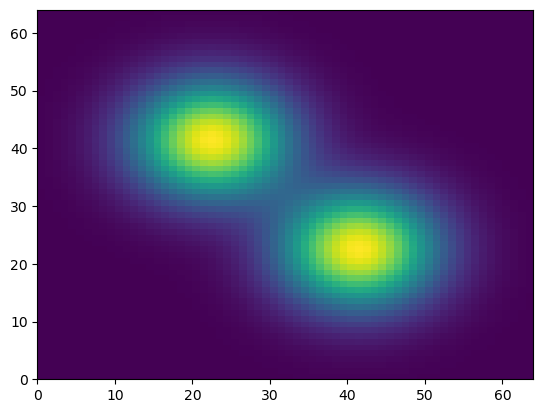

Iteration 	 100, time 	 0.078696, time remaining 	 0.921304


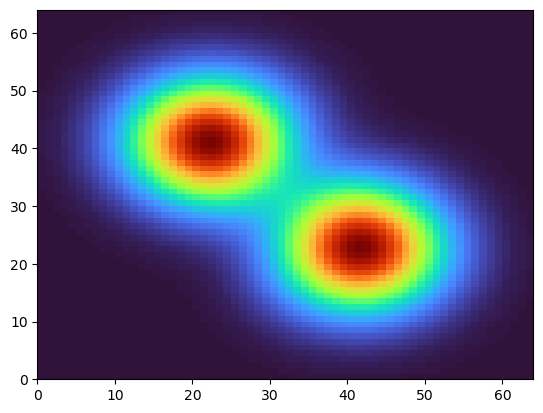

Iteration 	 200, time 	 0.158090, time remaining 	 0.841910


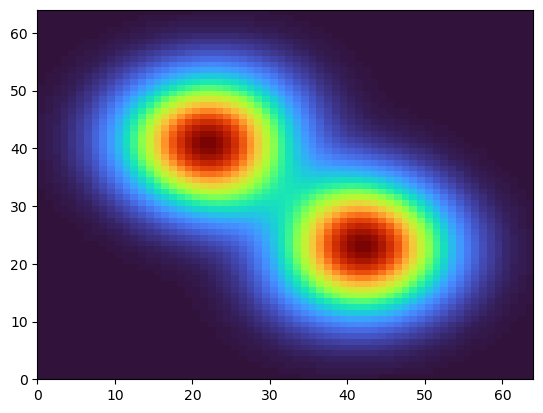

Iteration 	 300, time 	 0.237491, time remaining 	 0.762509


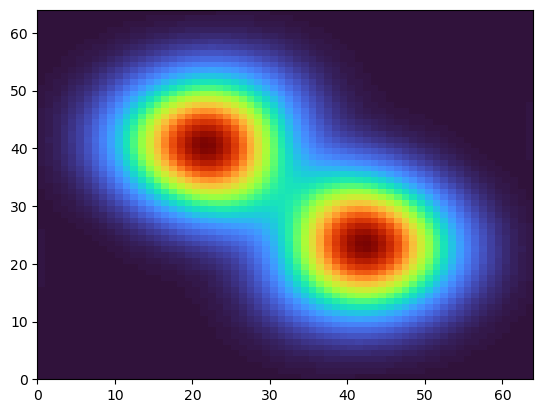

Iteration 	 400, time 	 0.316902, time remaining 	 0.683098


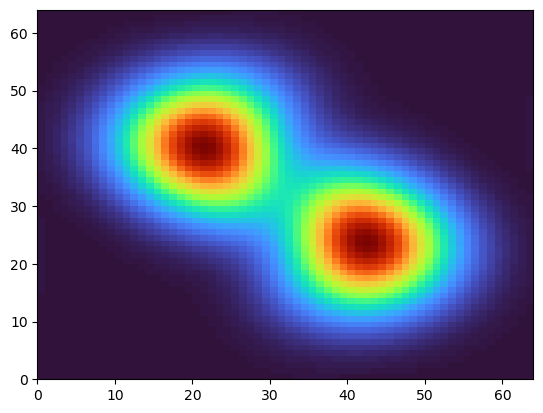

Iteration 	 500, time 	 0.396327, time remaining 	 0.603673


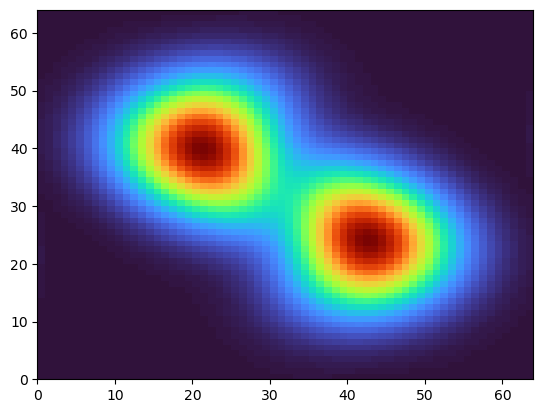

Iteration 	 600, time 	 0.475765, time remaining 	 0.524235


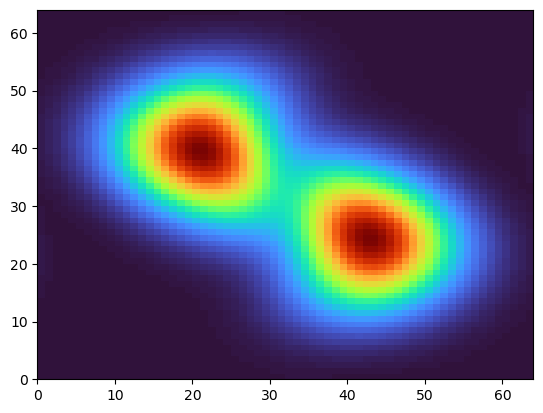

Iteration 	 700, time 	 0.555218, time remaining 	 0.444782


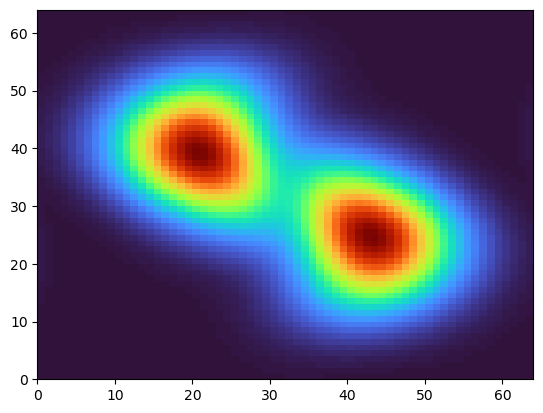

Iteration 	 800, time 	 0.634686, time remaining 	 0.365314


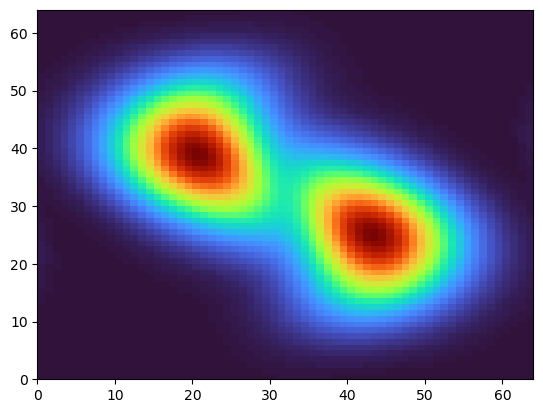

Iteration 	 900, time 	 0.714173, time remaining 	 0.285827


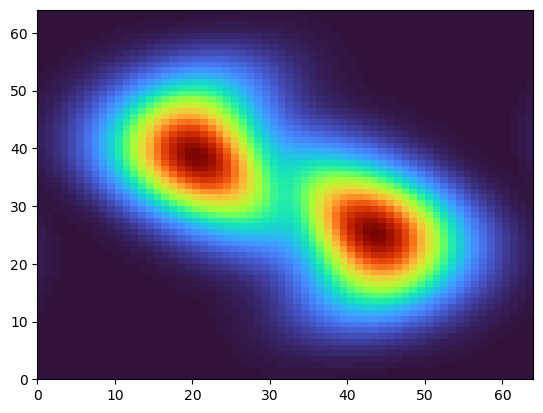

Iteration 	 1000, time 	 0.793677, time remaining 	 0.206323


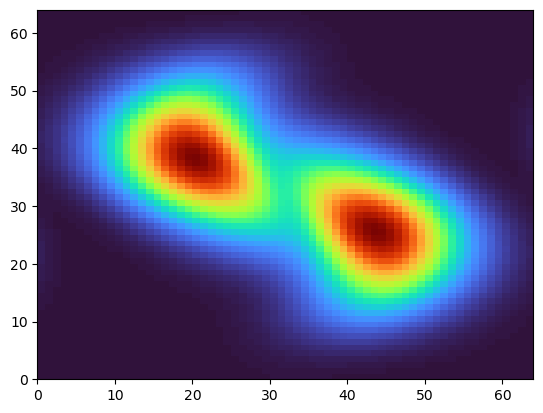

Iteration 	 1100, time 	 0.873180, time remaining 	 0.126820


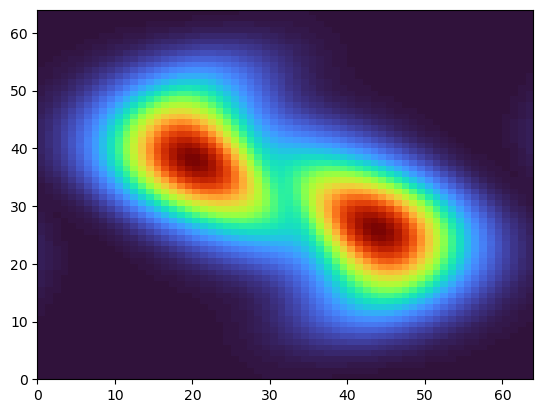

Iteration 	 1200, time 	 0.952681, time remaining 	 0.047319


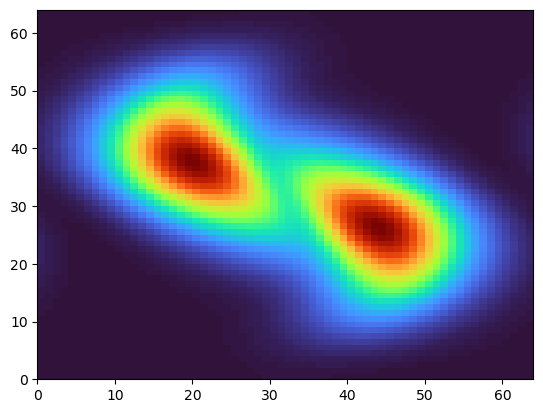

Iteration 	 1300, time 	 1.032182, time remaining 	 -0.032182


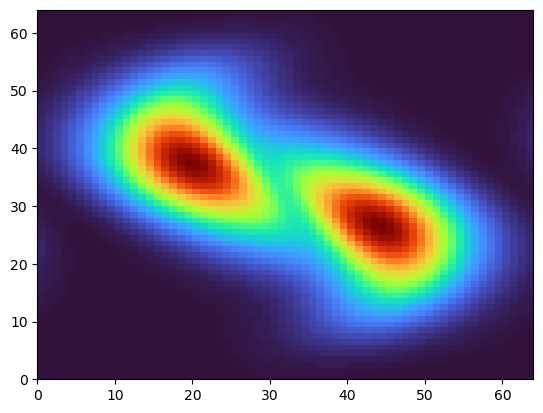

Iteration 	 1400, time 	 1.111683, time remaining 	 -0.111683


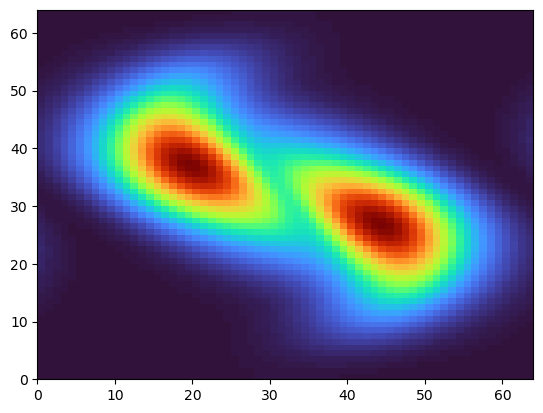

Iteration 	 1500, time 	 1.191183, time remaining 	 -0.191183


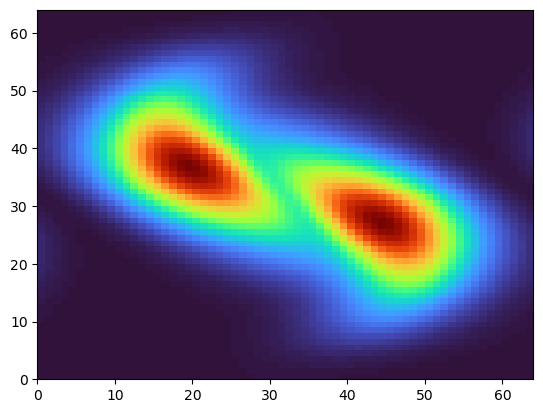

Iteration 	 1600, time 	 1.270683, time remaining 	 -0.270683


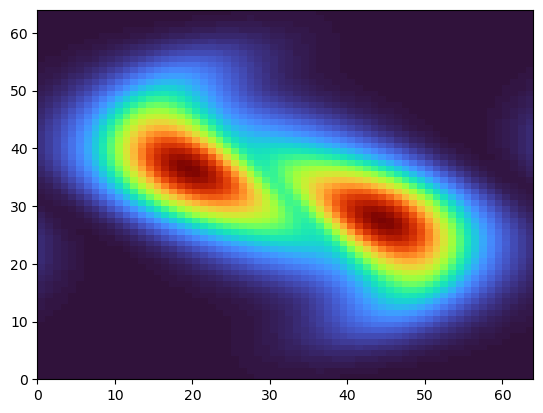

Iteration 	 1700, time 	 1.350186, time remaining 	 -0.350186


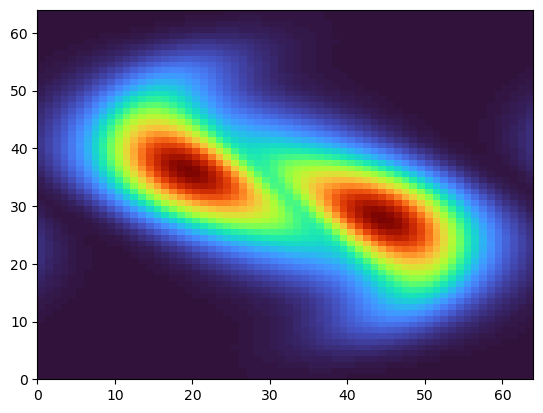

Iteration 	 1800, time 	 1.429692, time remaining 	 -0.429692


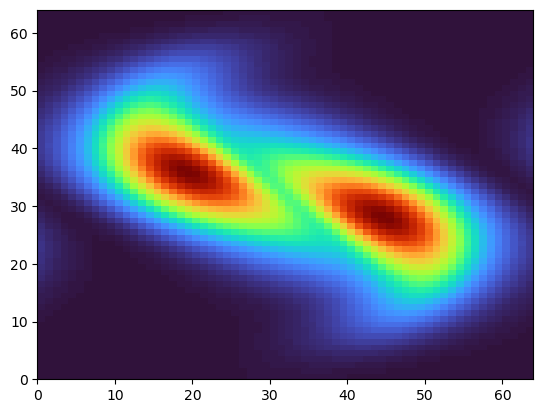

Iteration 	 1900, time 	 1.509201, time remaining 	 -0.509201


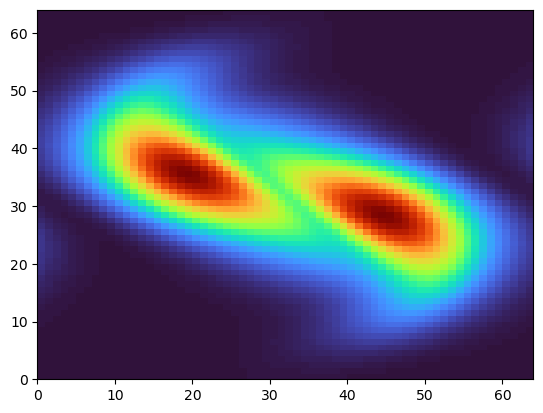

Iteration 	 2000, time 	 1.588714, time remaining 	 -0.588714


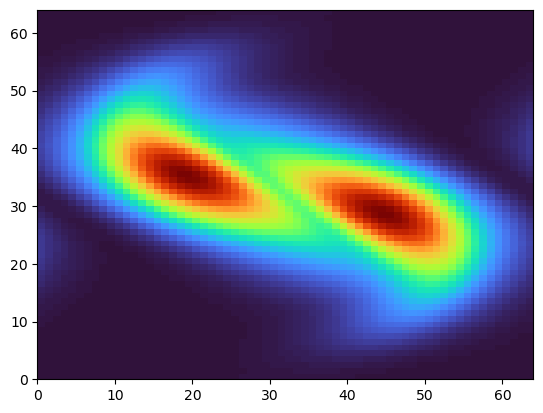

Iteration 	 2100, time 	 1.668235, time remaining 	 -0.668235


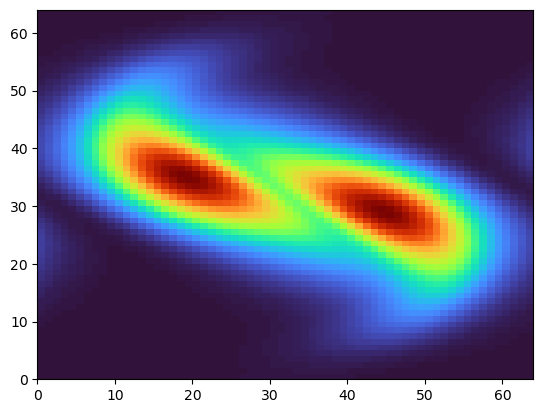

Iteration 	 2200, time 	 1.747763, time remaining 	 -0.747763


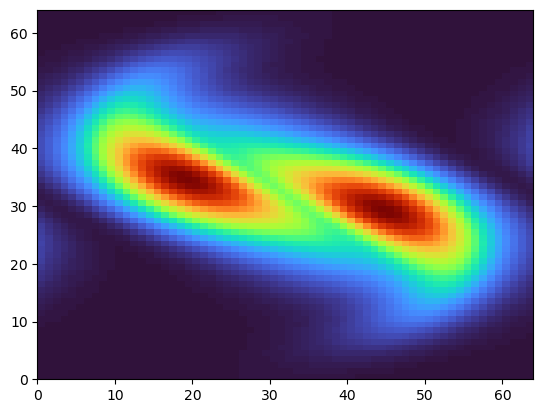

Iteration 	 2300, time 	 1.827297, time remaining 	 -0.827297


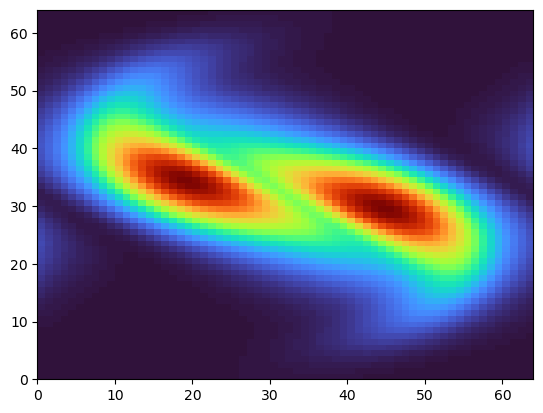

Iteration 	 2400, time 	 1.906836, time remaining 	 -0.906836


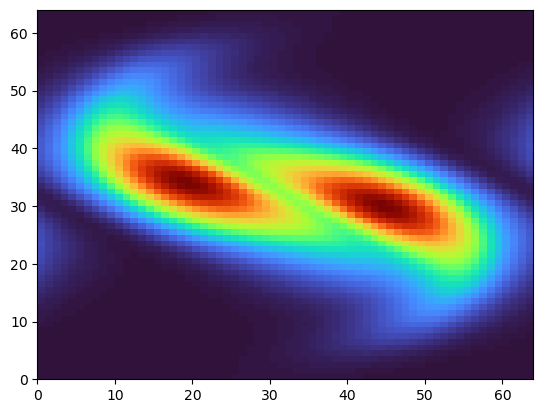

Iteration 	 2500, time 	 1.986382, time remaining 	 -0.986382


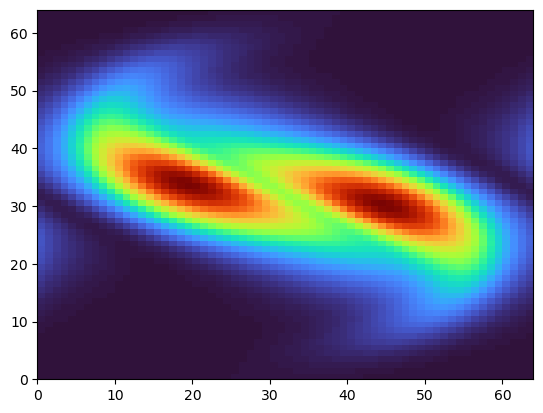

Iteration 	 2600, time 	 2.065935, time remaining 	 -1.065935


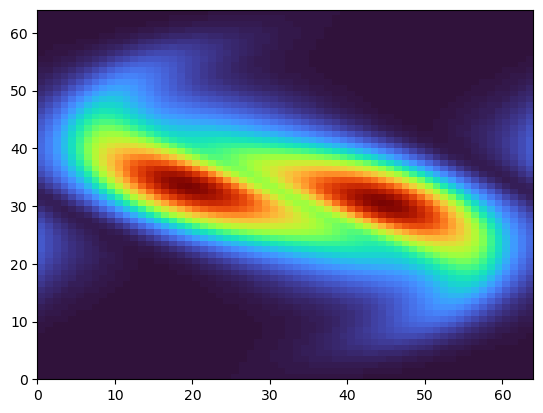

Iteration 	 2700, time 	 2.145496, time remaining 	 -1.145496


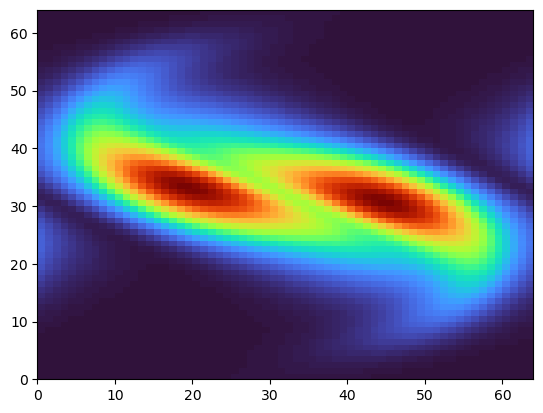

Iteration 	 2800, time 	 2.225066, time remaining 	 -1.225066


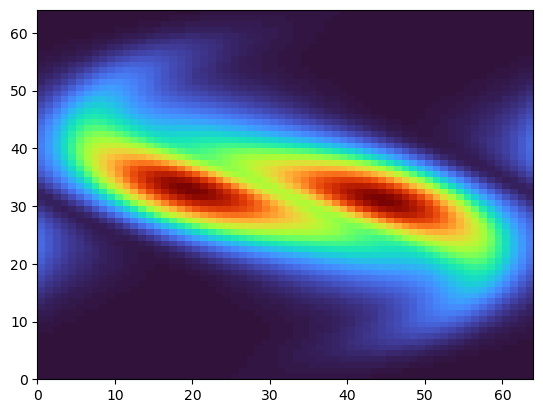

Iteration 	 2900, time 	 2.304643, time remaining 	 -1.304643


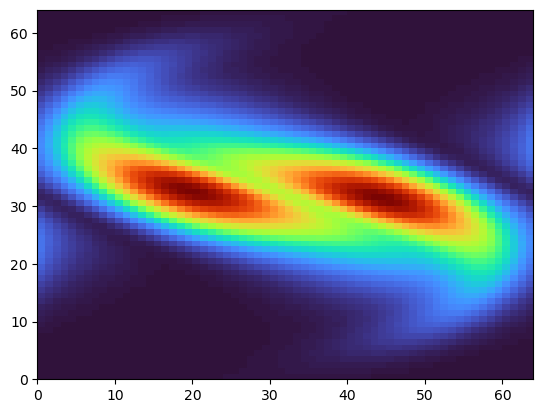

Iteration 	 3000, time 	 2.384226, time remaining 	 -1.384226


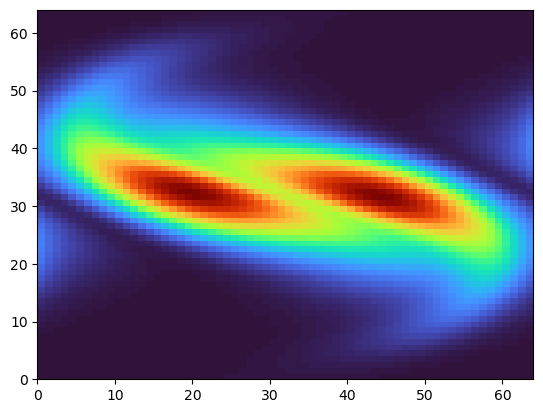

Iteration 	 3100, time 	 2.463814, time remaining 	 -1.463814


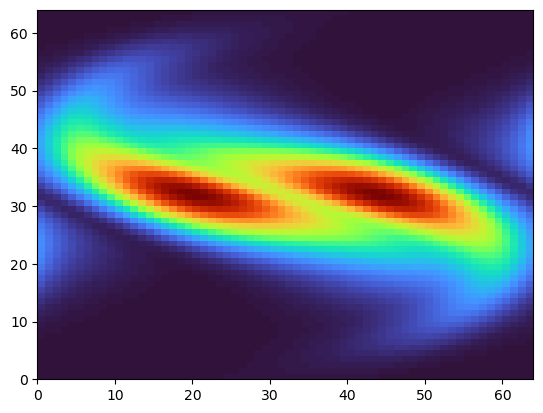

Iteration 	 3200, time 	 2.543409, time remaining 	 -1.543409


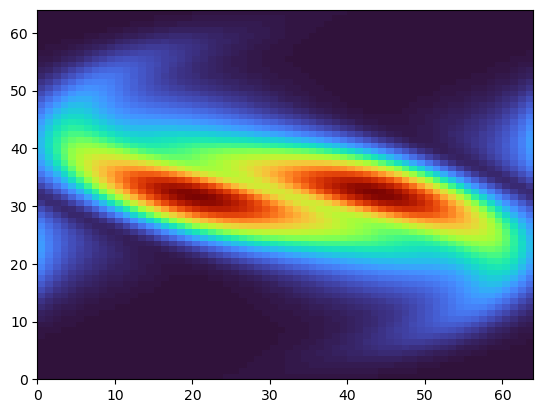

Iteration 	 3300, time 	 2.623011, time remaining 	 -1.623011


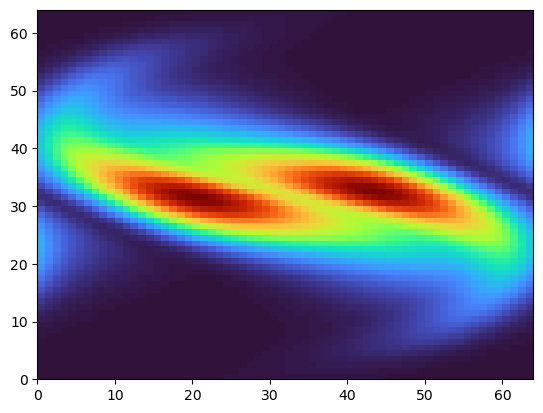

Iteration 	 3400, time 	 2.702622, time remaining 	 -1.702622


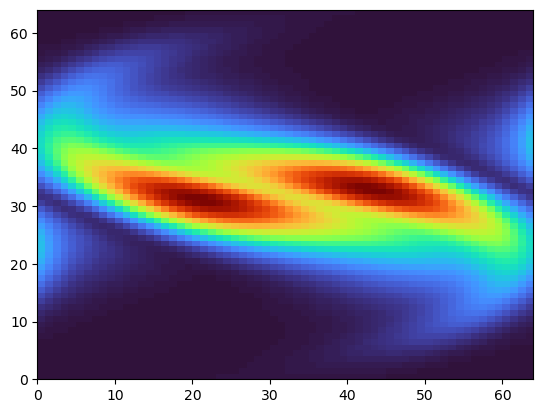

Iteration 	 3500, time 	 2.782240, time remaining 	 -1.782240


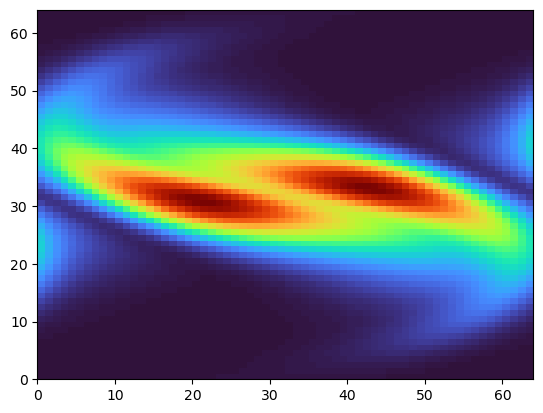

Iteration 	 3600, time 	 2.861866, time remaining 	 -1.861866


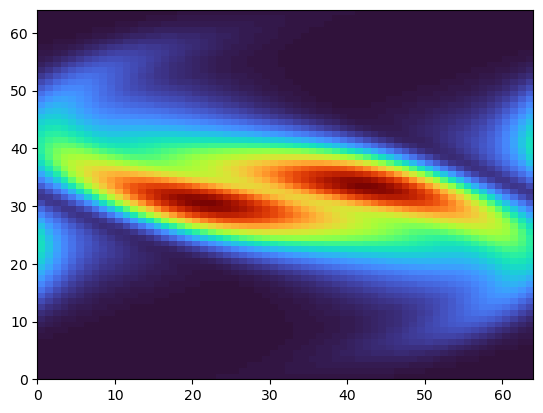

Iteration 	 3700, time 	 2.941496, time remaining 	 -1.941496


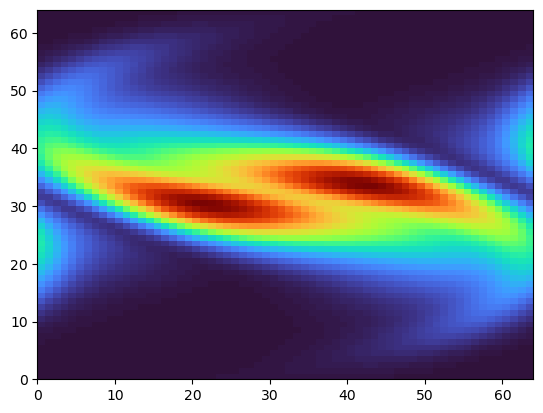

Iteration 	 3800, time 	 3.021131, time remaining 	 -2.021131


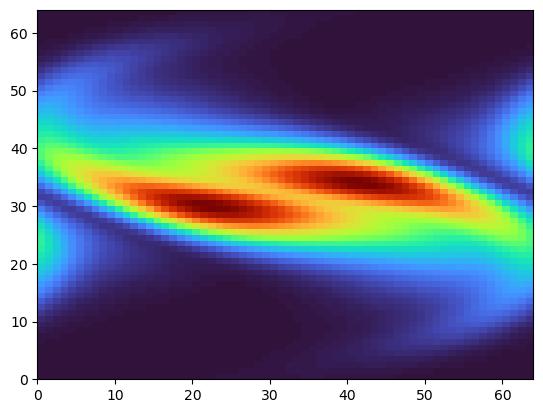

Iteration 	 3900, time 	 3.100772, time remaining 	 -2.100772


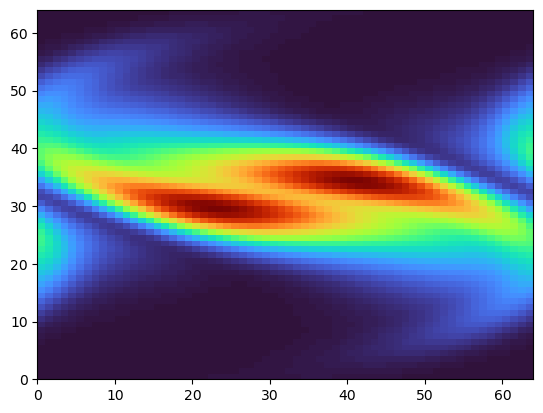

Iteration 	 4000, time 	 3.180420, time remaining 	 -2.180420


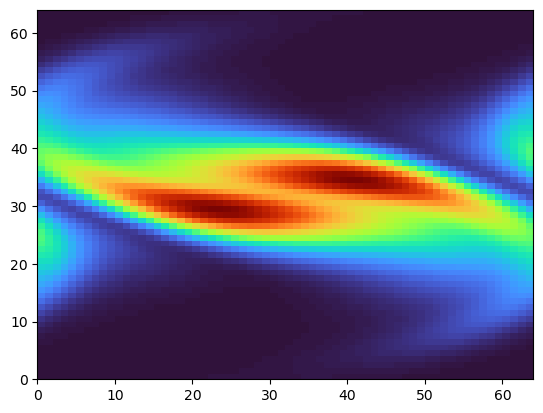

Iteration 	 4100, time 	 3.260077, time remaining 	 -2.260077


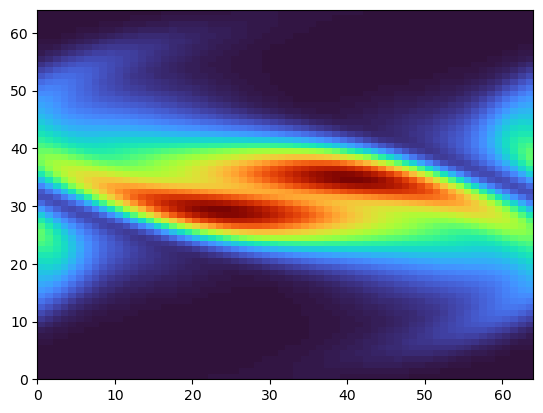

Iteration 	 4200, time 	 3.339742, time remaining 	 -2.339742


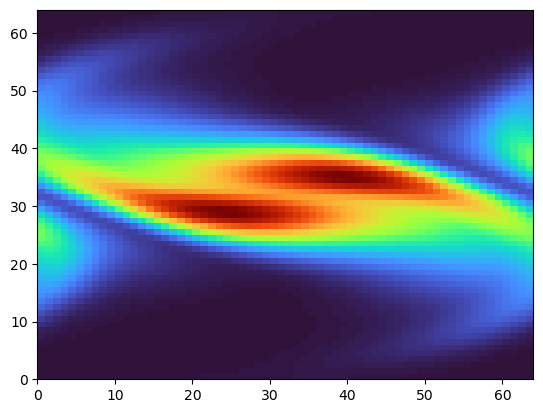

Iteration 	 4300, time 	 3.419415, time remaining 	 -2.419415


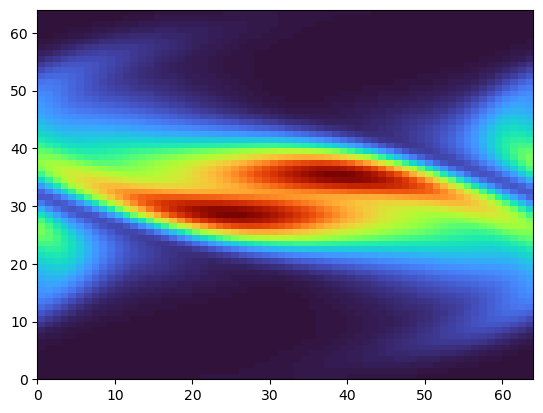

Iteration 	 4400, time 	 3.499099, time remaining 	 -2.499099


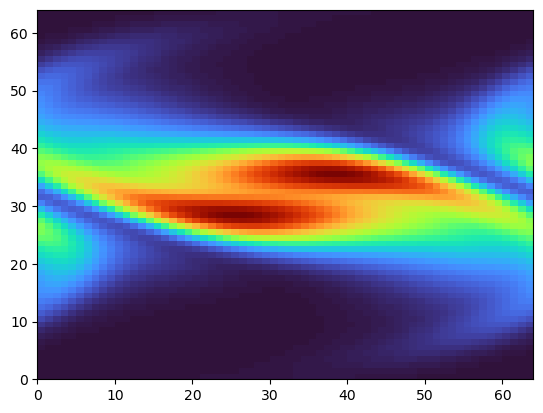

Iteration 	 4500, time 	 3.578795, time remaining 	 -2.578795


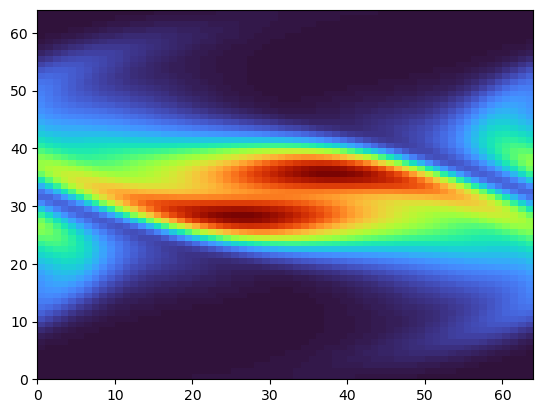

Iteration 	 4600, time 	 3.658503, time remaining 	 -2.658503


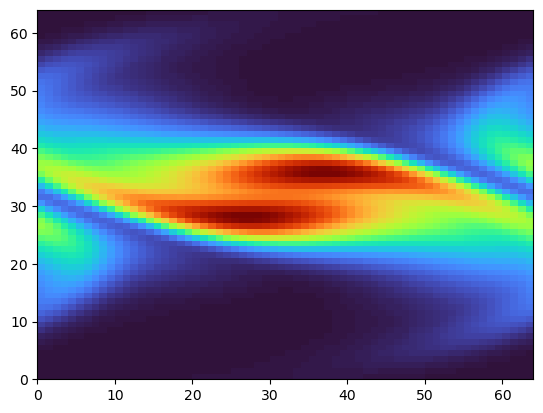

Iteration 	 4700, time 	 3.738222, time remaining 	 -2.738222


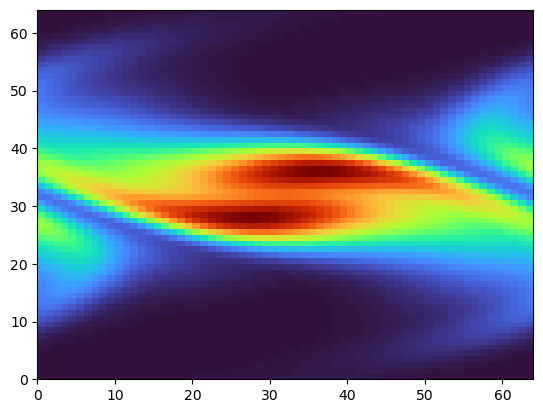

Iteration 	 4800, time 	 3.817952, time remaining 	 -2.817952


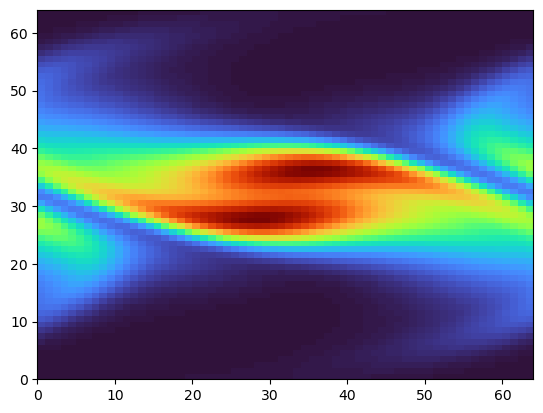

Iteration 	 4900, time 	 3.897697, time remaining 	 -2.897697


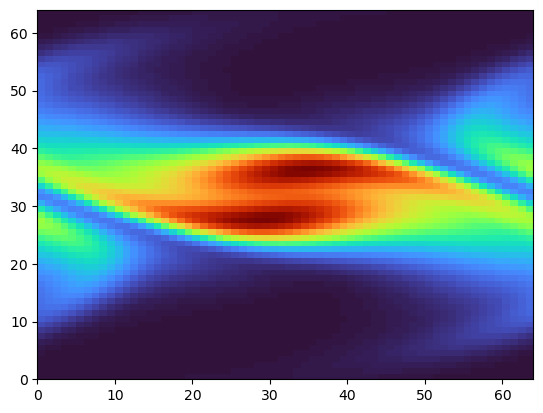

Iteration 	 5000, time 	 3.977456, time remaining 	 -2.977456


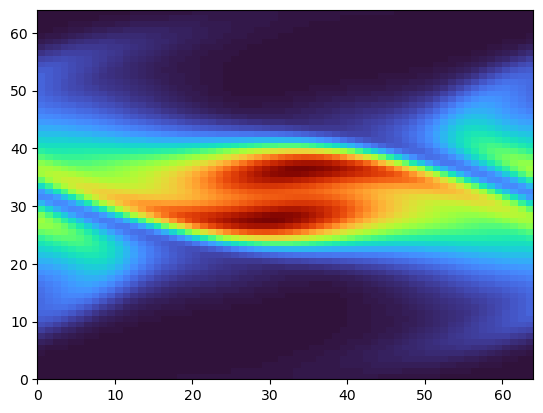

Iteration 	 5100, time 	 4.057231, time remaining 	 -3.057231


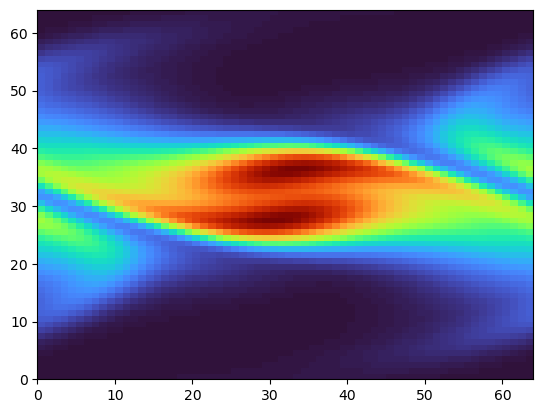

Iteration 	 5200, time 	 4.137025, time remaining 	 -3.137025


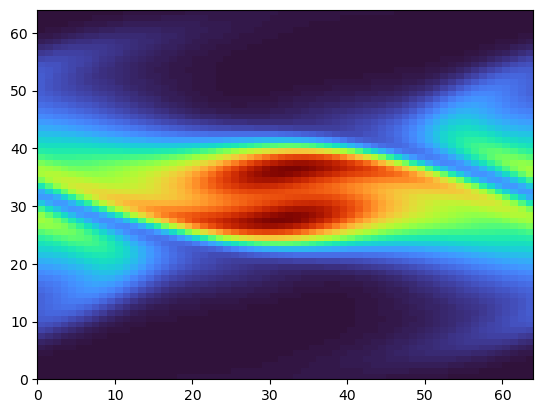

Iteration 	 5300, time 	 4.216840, time remaining 	 -3.216840


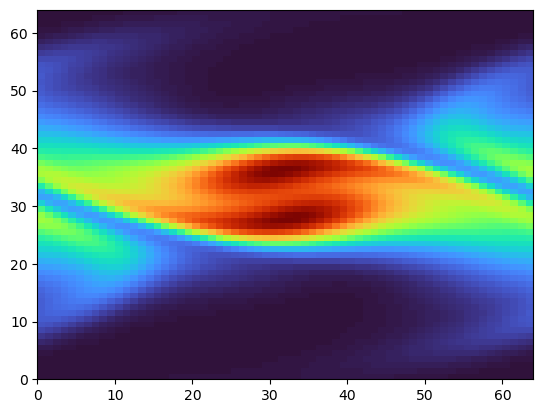

Iteration 	 5400, time 	 4.296670, time remaining 	 -3.296670


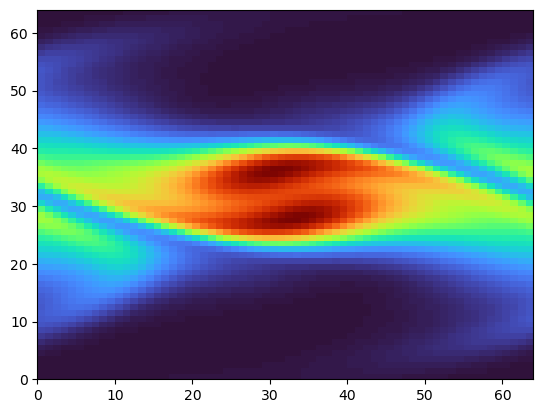

Iteration 	 5500, time 	 4.376487, time remaining 	 -3.376487


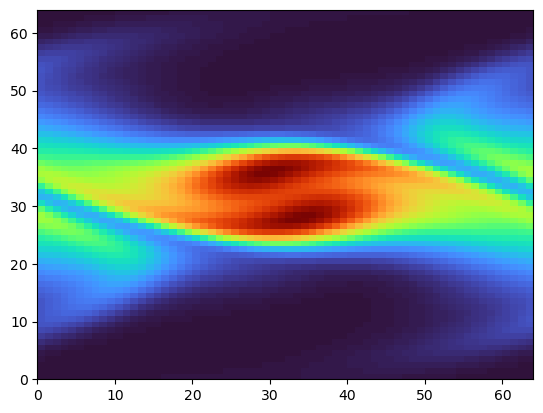

Iteration 	 5600, time 	 4.456290, time remaining 	 -3.456290


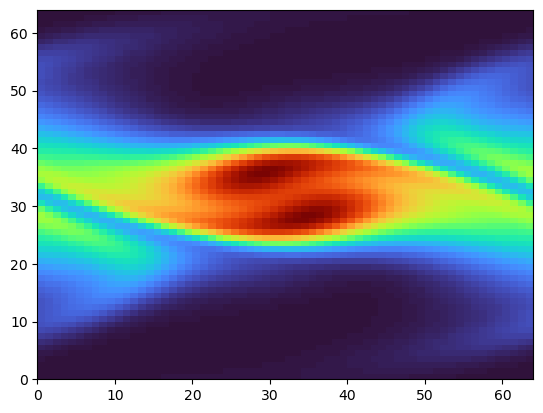

Iteration 	 5700, time 	 4.536081, time remaining 	 -3.536081


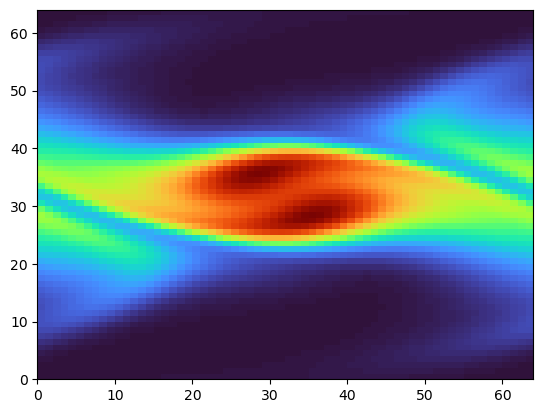

Iteration 	 5800, time 	 4.615863, time remaining 	 -3.615863


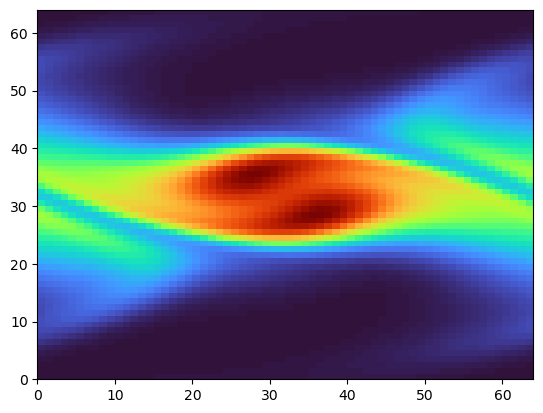

Iteration 	 5900, time 	 4.695638, time remaining 	 -3.695638


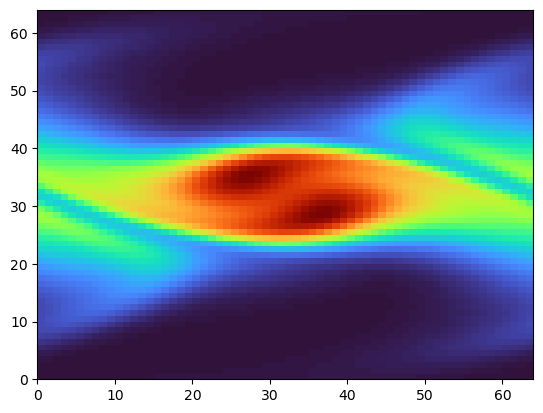

Iteration 	 6000, time 	 4.775406, time remaining 	 -3.775406


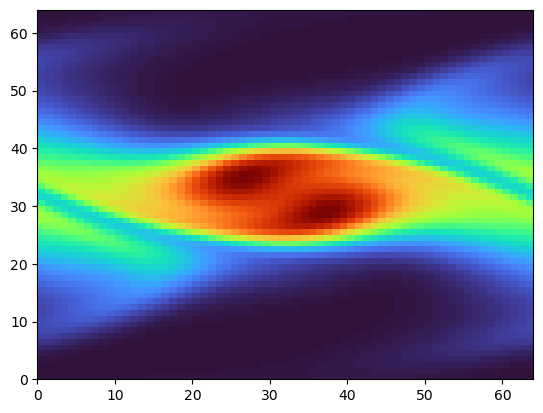

Iteration 	 6100, time 	 4.855171, time remaining 	 -3.855171


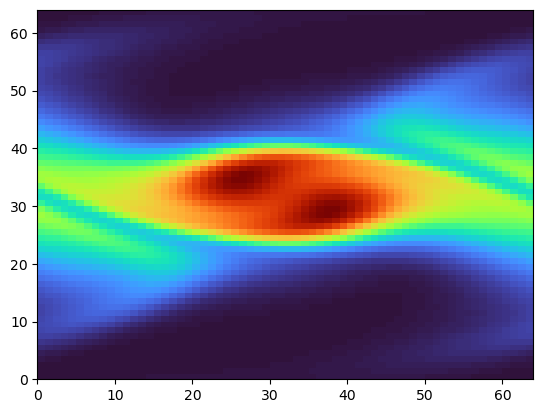

Iteration 	 6200, time 	 4.934935, time remaining 	 -3.934935


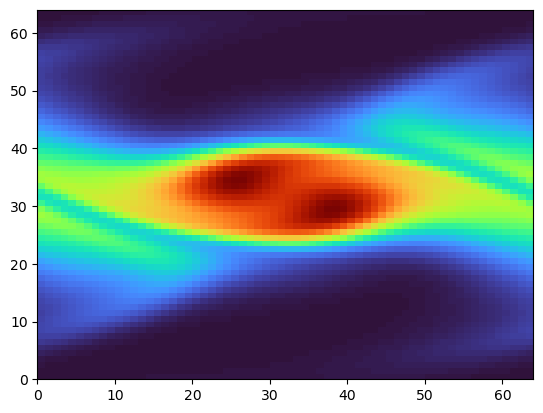

Iteration 	 6300, time 	 5.014698, time remaining 	 -4.014698


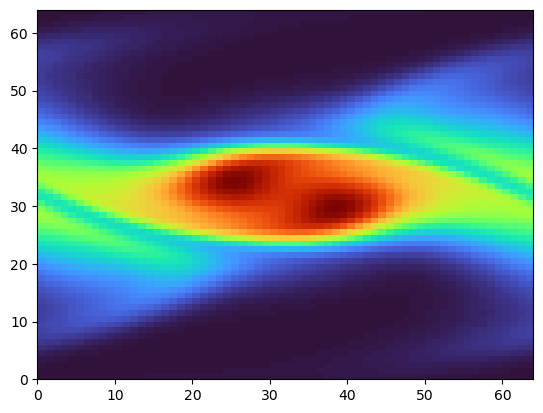

Iteration 	 6400, time 	 5.094462, time remaining 	 -4.094462


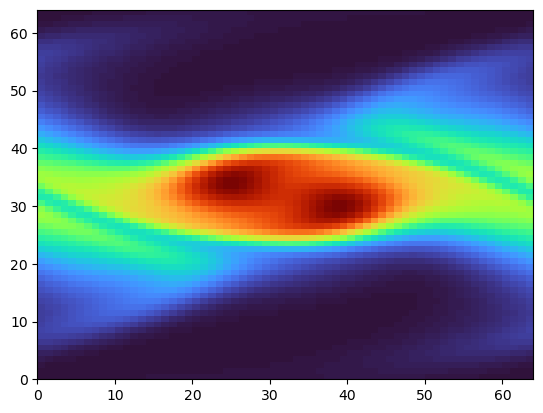

Iteration 	 6500, time 	 5.174230, time remaining 	 -4.174230


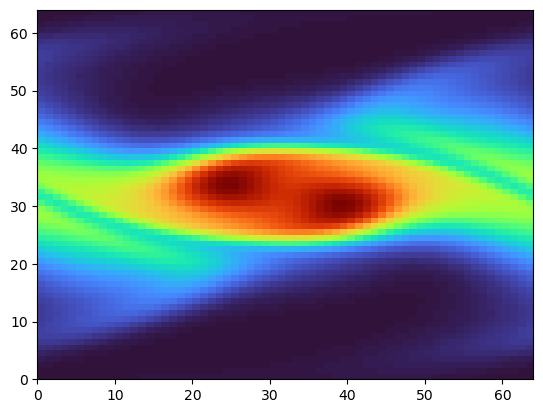

Iteration 	 6600, time 	 5.254004, time remaining 	 -4.254004


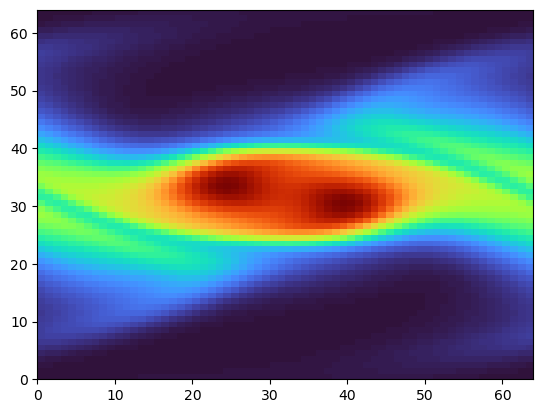

Iteration 	 6700, time 	 5.333782, time remaining 	 -4.333782


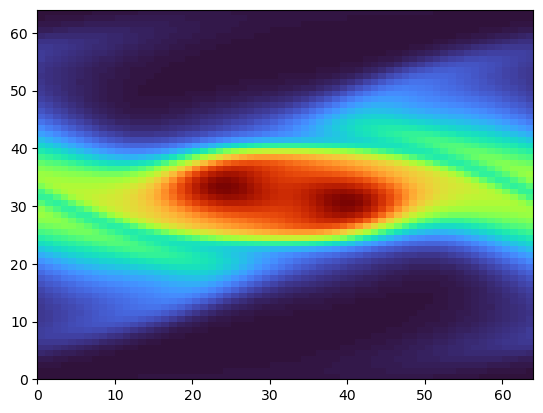

Iteration 	 6800, time 	 5.413566, time remaining 	 -4.413566


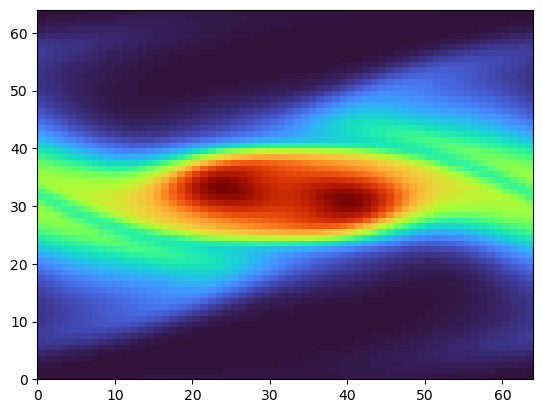

Iteration 	 6900, time 	 5.493356, time remaining 	 -4.493356


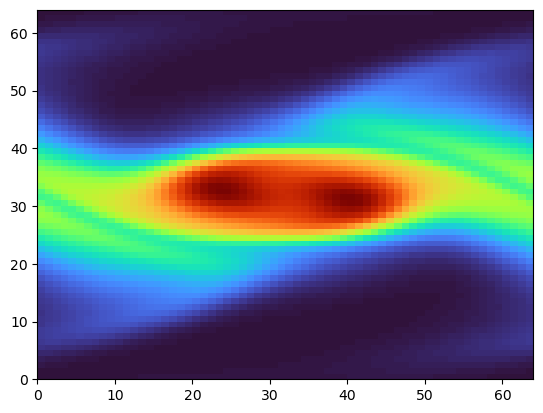

Iteration 	 7000, time 	 5.573152, time remaining 	 -4.573152


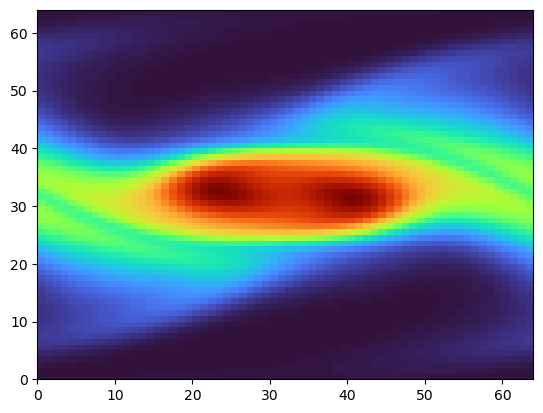

Iteration 	 7100, time 	 5.652957, time remaining 	 -4.652957


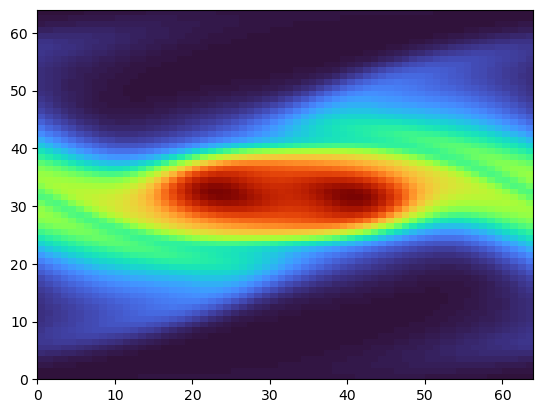

Iteration 	 7200, time 	 5.732769, time remaining 	 -4.732769


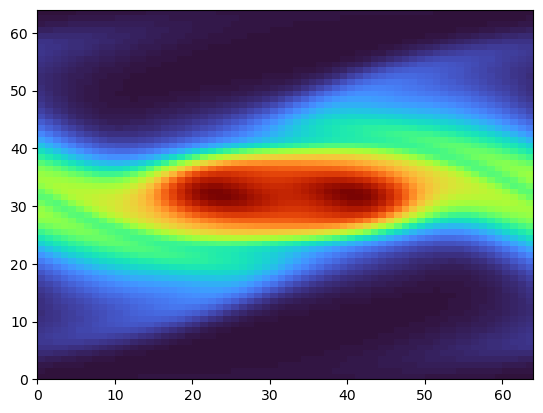

Iteration 	 7300, time 	 5.812591, time remaining 	 -4.812591


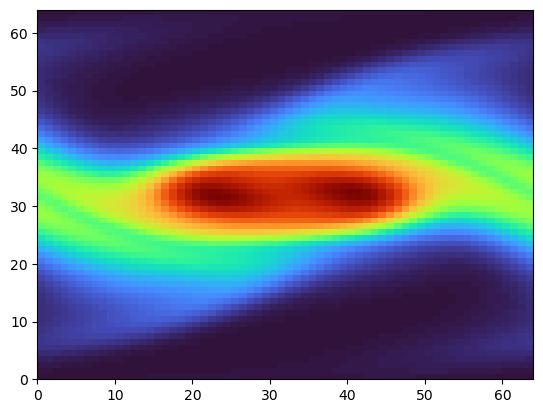

Iteration 	 7400, time 	 5.892422, time remaining 	 -4.892422


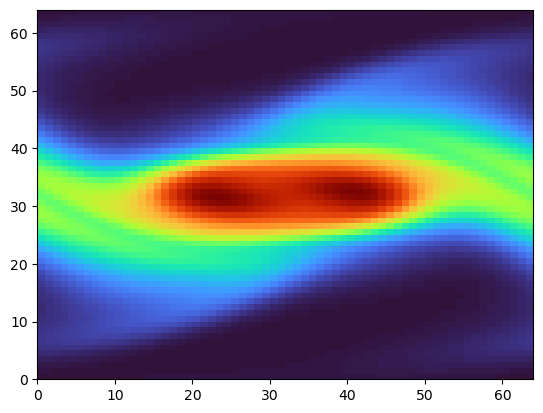

Iteration 	 7500, time 	 5.972262, time remaining 	 -4.972262


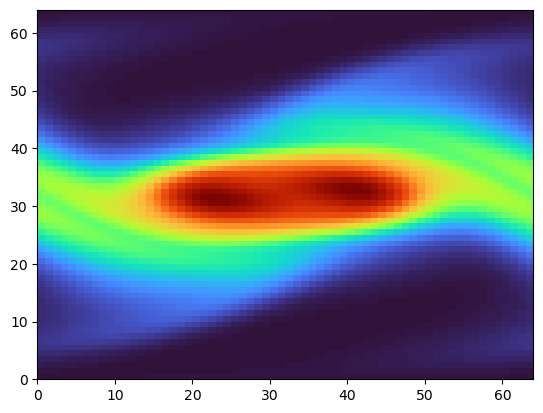

Iteration 	 7600, time 	 6.052113, time remaining 	 -5.052113


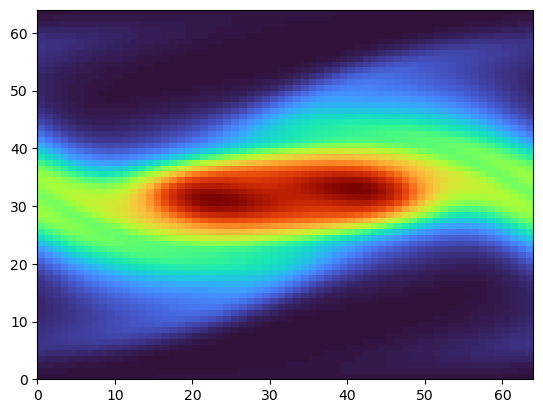

Iteration 	 7700, time 	 6.131974, time remaining 	 -5.131974


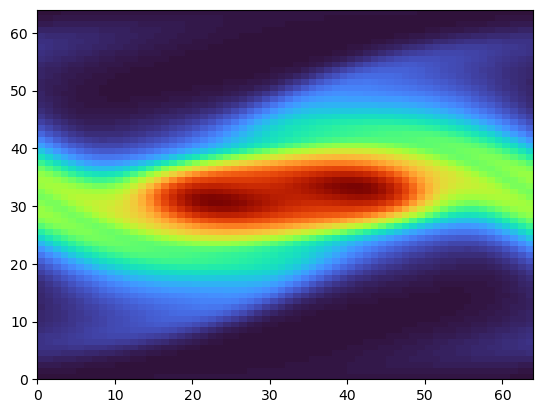

Iteration 	 7800, time 	 6.211845, time remaining 	 -5.211845


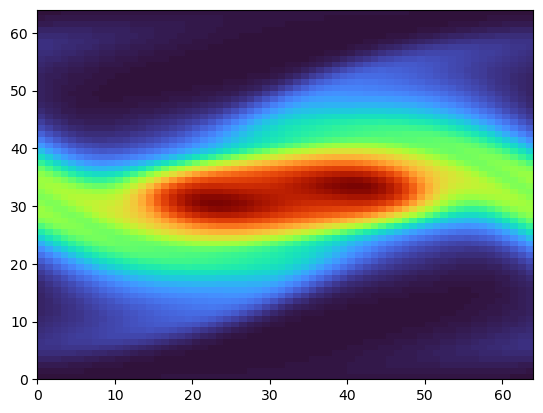

Iteration 	 7900, time 	 6.291726, time remaining 	 -5.291726


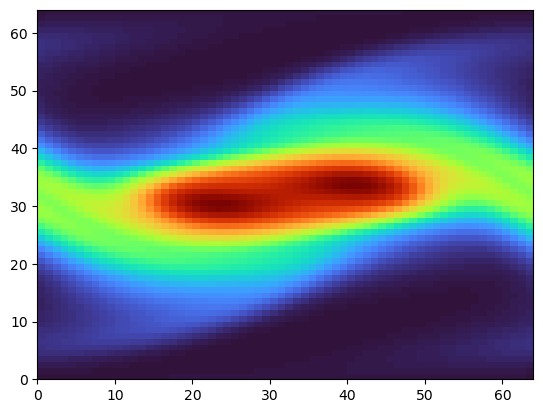

Iteration 	 8000, time 	 6.371615, time remaining 	 -5.371615


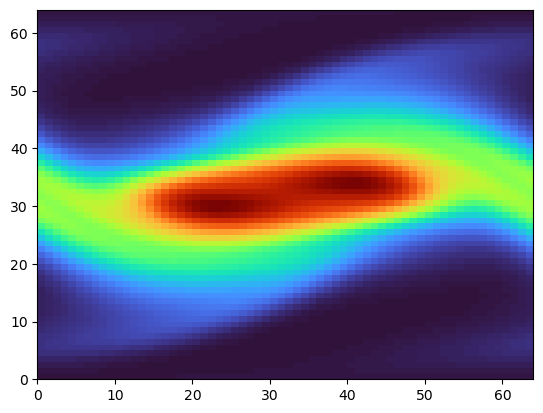

Iteration 	 8100, time 	 6.451514, time remaining 	 -5.451514


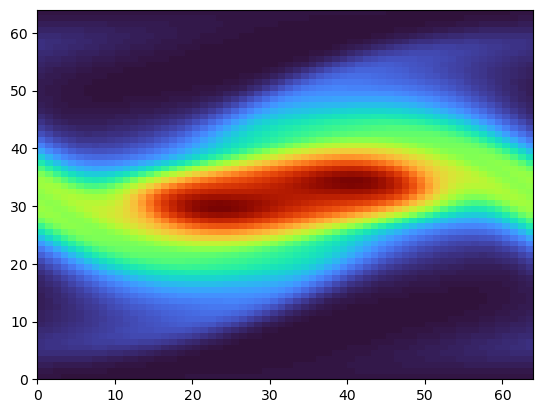

Iteration 	 8200, time 	 6.531419, time remaining 	 -5.531419


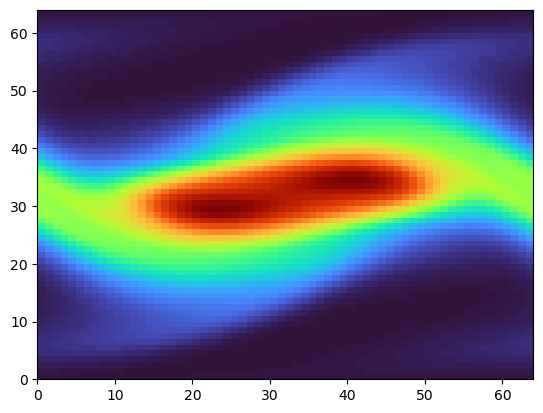

Iteration 	 8300, time 	 6.611329, time remaining 	 -5.611329


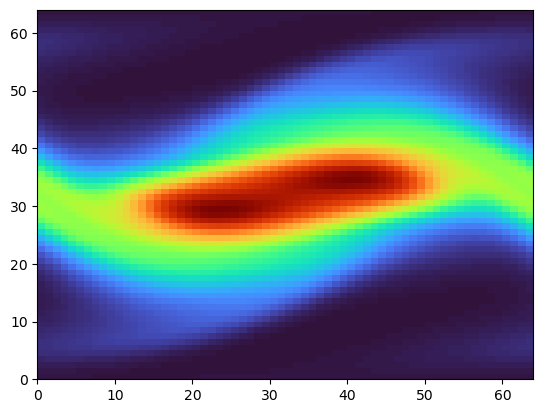

Iteration 	 8400, time 	 6.691243, time remaining 	 -5.691243


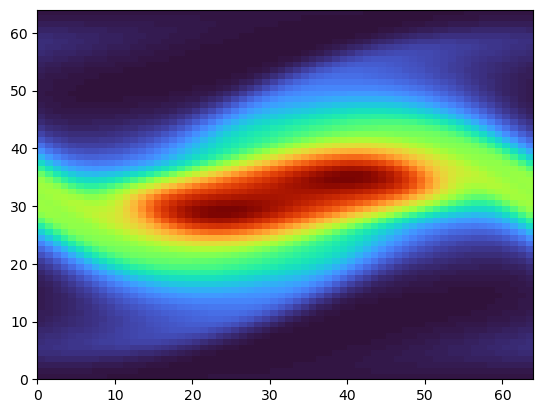

Iteration 	 8500, time 	 6.771159, time remaining 	 -5.771159


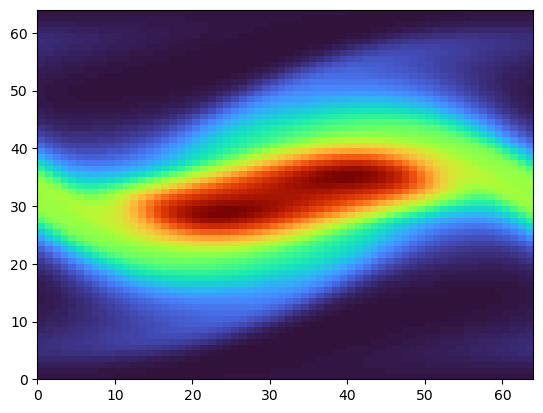

Iteration 	 8600, time 	 6.851076, time remaining 	 -5.851076


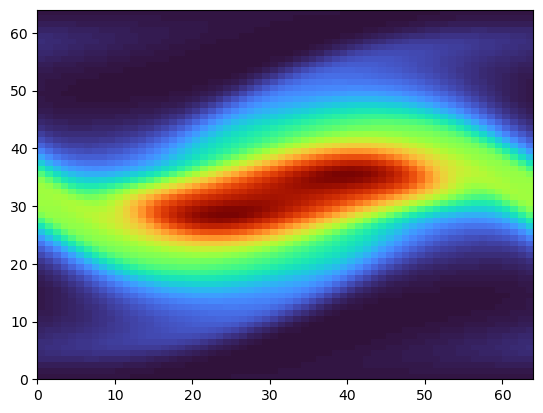

Iteration 	 8700, time 	 6.930995, time remaining 	 -5.930995


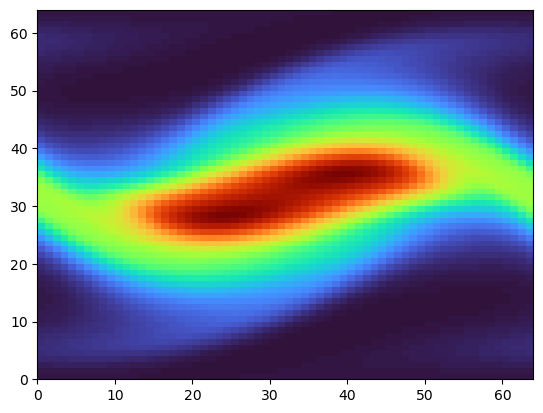

Iteration 	 8800, time 	 7.010914, time remaining 	 -6.010914


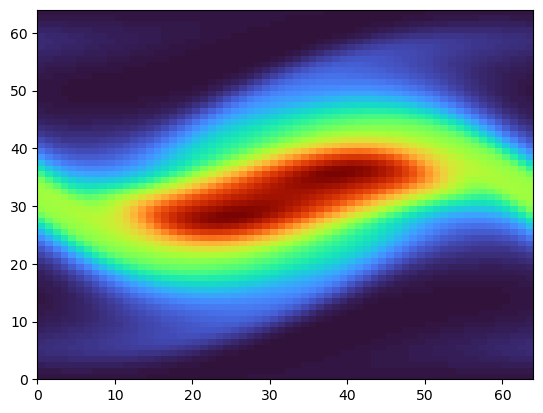

Iteration 	 8900, time 	 7.090834, time remaining 	 -6.090834


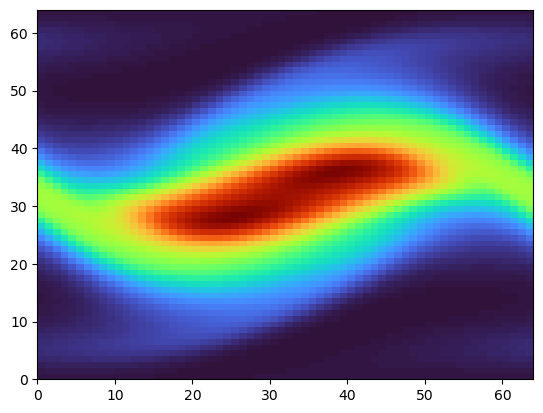

Iteration 	 9000, time 	 7.170752, time remaining 	 -6.170752


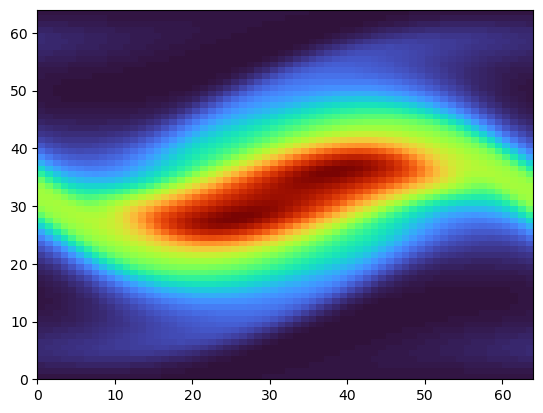

Iteration 	 9100, time 	 7.250669, time remaining 	 -6.250669


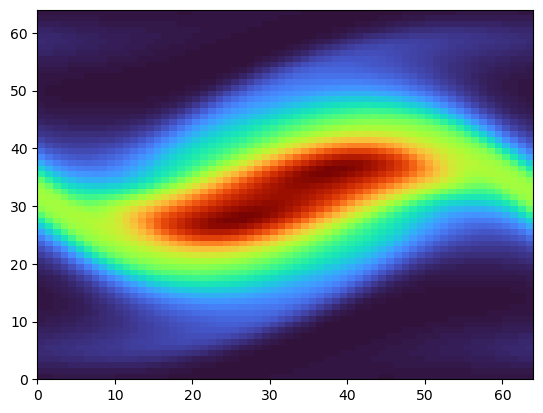

Iteration 	 9200, time 	 7.330581, time remaining 	 -6.330581


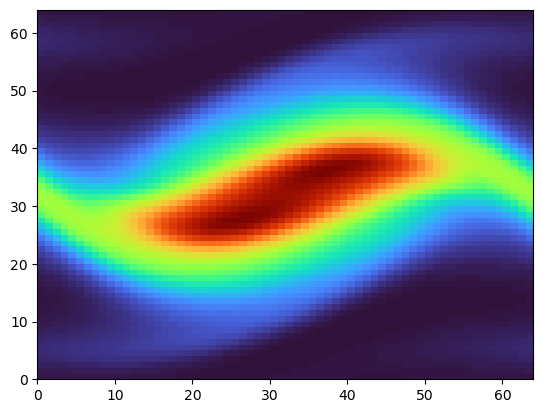

Iteration 	 9300, time 	 7.410489, time remaining 	 -6.410489


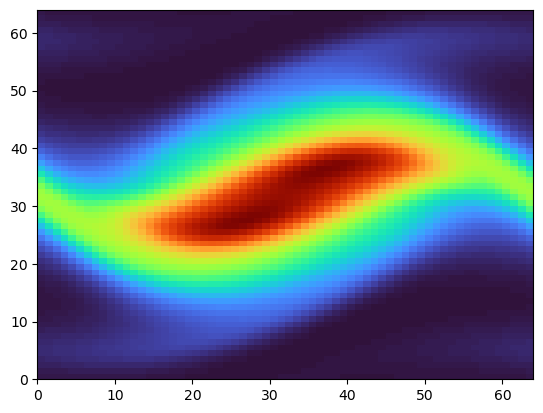

Iteration 	 9400, time 	 7.490389, time remaining 	 -6.490389


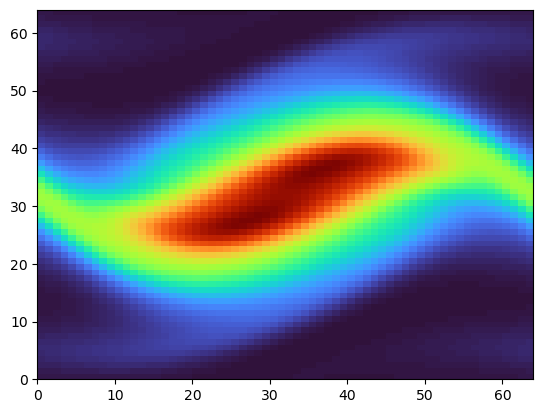

Iteration 	 9500, time 	 7.570282, time remaining 	 -6.570282


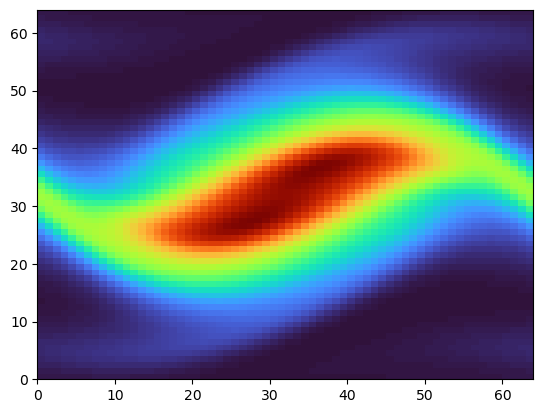

Iteration 	 9600, time 	 7.650167, time remaining 	 -6.650167


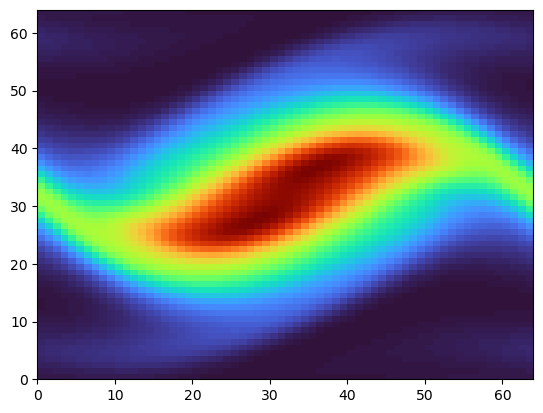

Iteration 	 9700, time 	 7.730042, time remaining 	 -6.730042


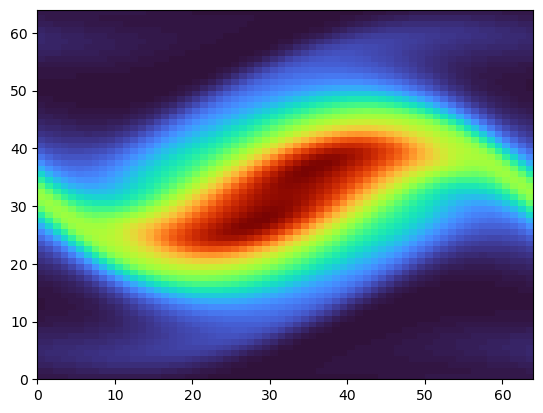

Iteration 	 9800, time 	 7.809909, time remaining 	 -6.809909


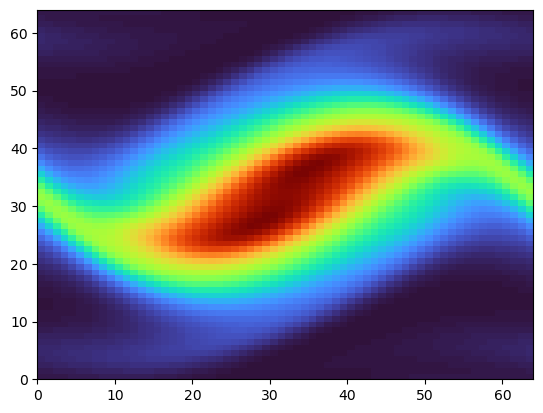

Iteration 	 9900, time 	 7.889766, time remaining 	 -6.889766


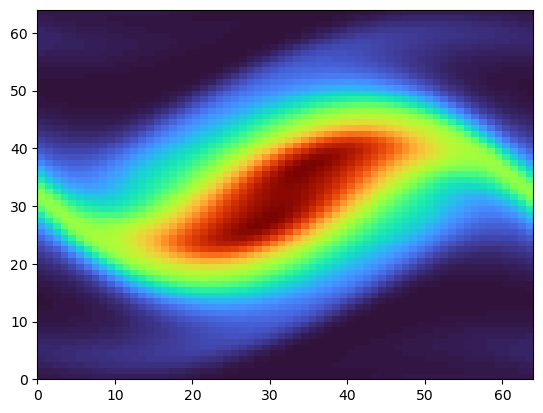

Iteration 	 10000, time 	 7.969613, time remaining 	 -6.969613


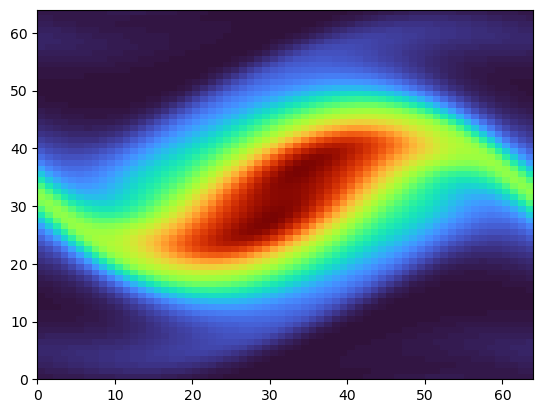

Iteration 	 10100, time 	 8.049449, time remaining 	 -7.049449


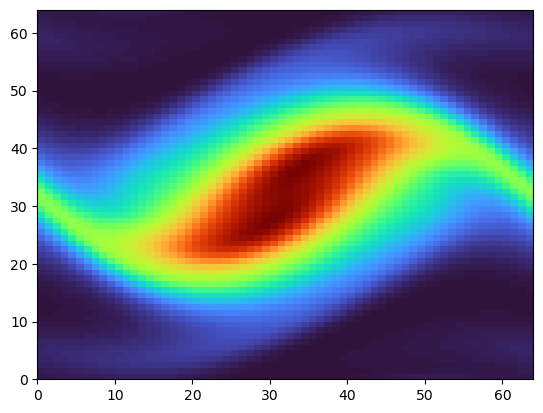

Iteration 	 10200, time 	 8.129274, time remaining 	 -7.129274


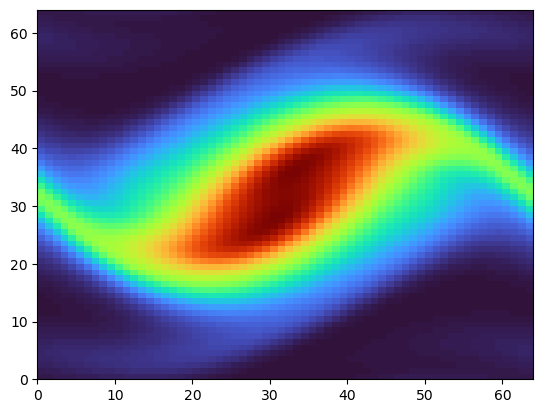

Iteration 	 10300, time 	 8.209088, time remaining 	 -7.209088


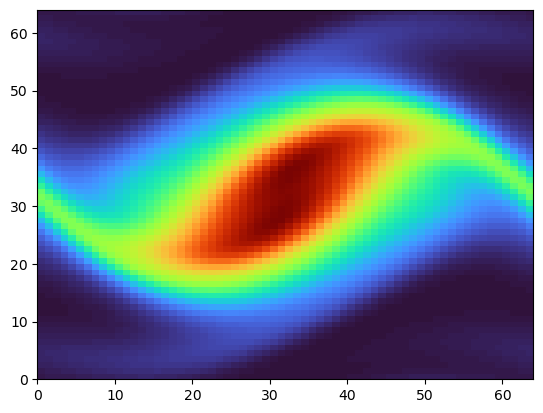

Iteration 	 10400, time 	 8.288891, time remaining 	 -7.288891


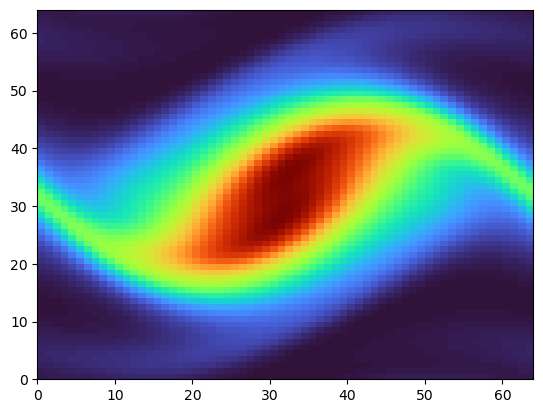

Iteration 	 10500, time 	 8.368683, time remaining 	 -7.368683


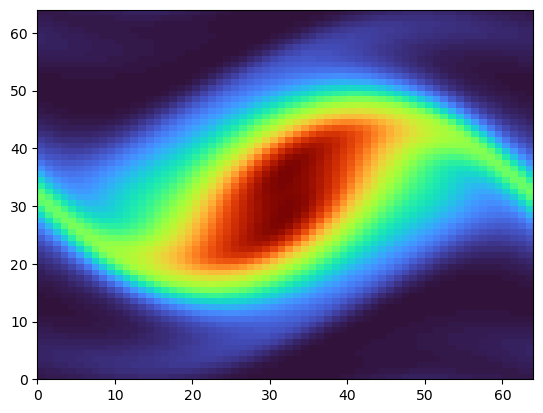

Iteration 	 10600, time 	 8.448465, time remaining 	 -7.448465


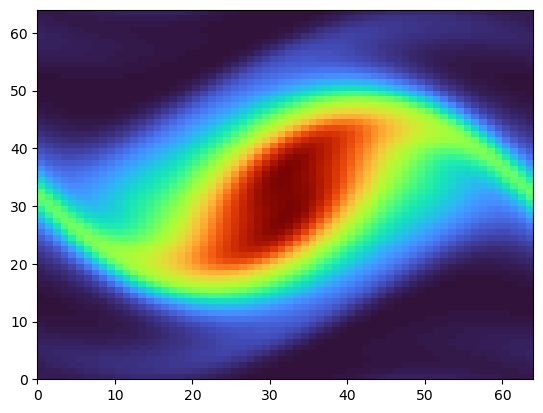

Iteration 	 10700, time 	 8.528234, time remaining 	 -7.528234


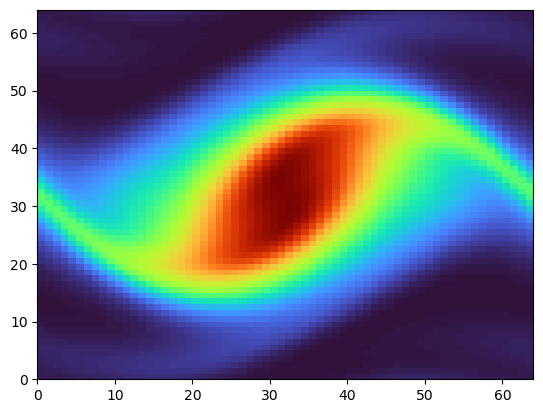

Iteration 	 10800, time 	 8.607992, time remaining 	 -7.607992


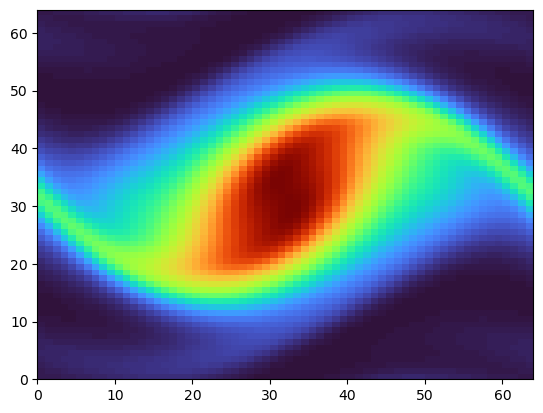

Iteration 	 10900, time 	 8.687738, time remaining 	 -7.687738


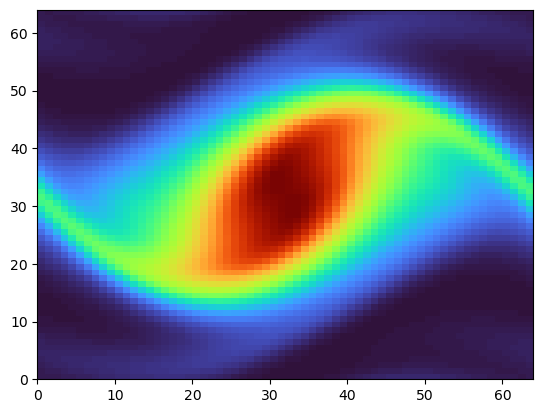

Iteration 	 11000, time 	 8.767473, time remaining 	 -7.767473


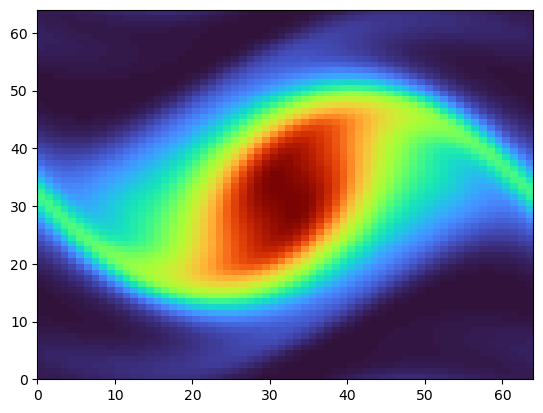

Iteration 	 11100, time 	 8.847197, time remaining 	 -7.847197


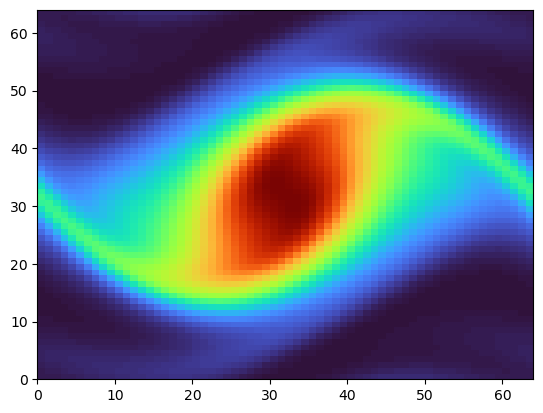

Iteration 	 11200, time 	 8.926911, time remaining 	 -7.926911


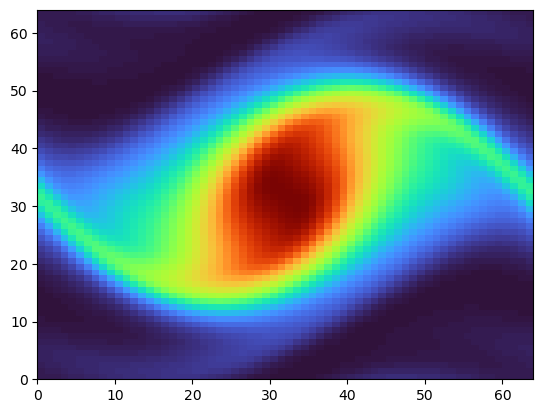

Iteration 	 11300, time 	 9.006614, time remaining 	 -8.006614


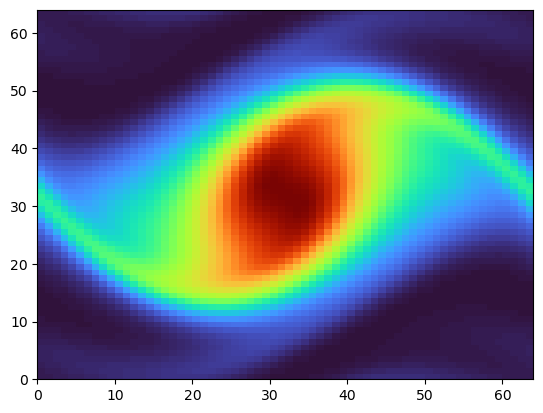

Iteration 	 11400, time 	 9.086307, time remaining 	 -8.086307


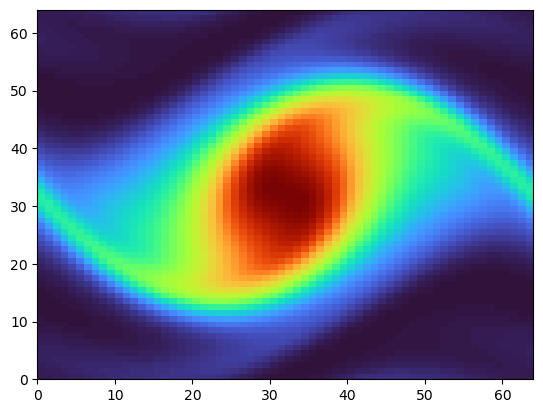

Iteration 	 11500, time 	 9.165990, time remaining 	 -8.165990


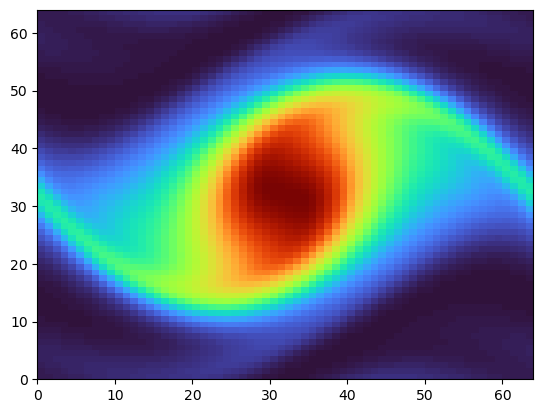

Iteration 	 11600, time 	 9.245665, time remaining 	 -8.245665


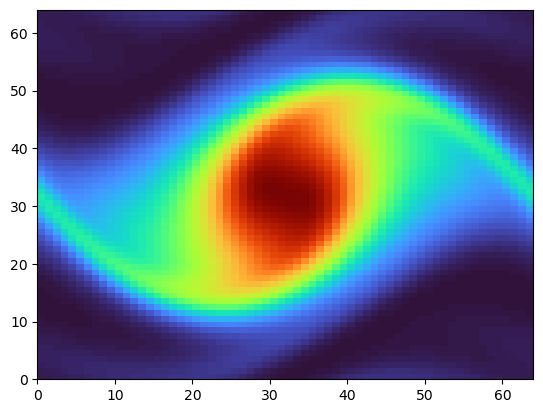

Iteration 	 11700, time 	 9.325332, time remaining 	 -8.325332


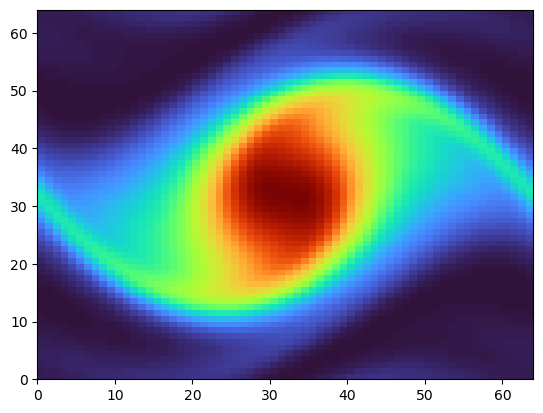

Iteration 	 11800, time 	 9.404994, time remaining 	 -8.404994


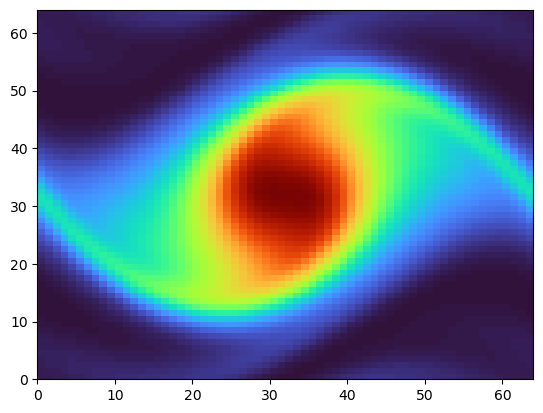

Iteration 	 11900, time 	 9.484649, time remaining 	 -8.484649


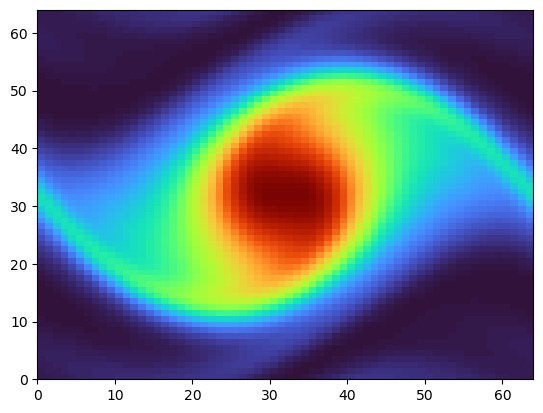

Iteration 	 12000, time 	 9.564298, time remaining 	 -8.564298


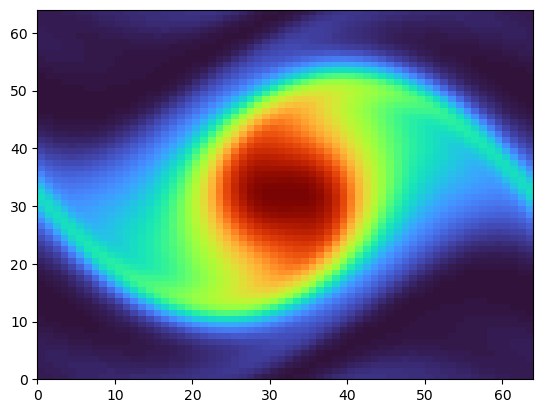

Iteration 	 12100, time 	 9.643943, time remaining 	 -8.643943


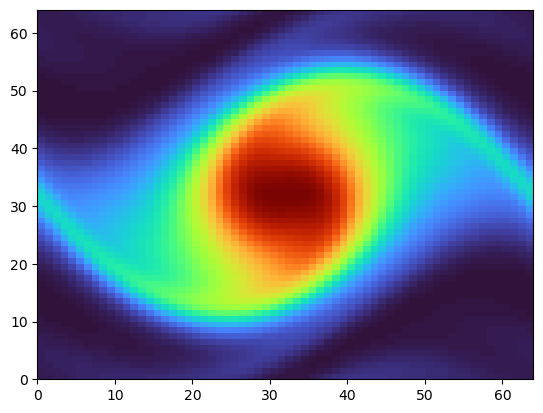

Iteration 	 12200, time 	 9.723585, time remaining 	 -8.723585


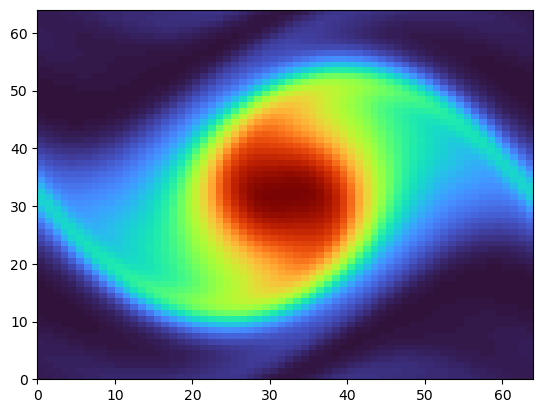

Iteration 	 12300, time 	 9.803226, time remaining 	 -8.803226


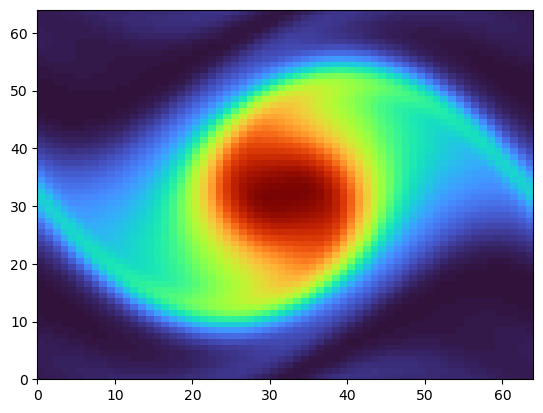

Iteration 	 12400, time 	 9.882866, time remaining 	 -8.882866


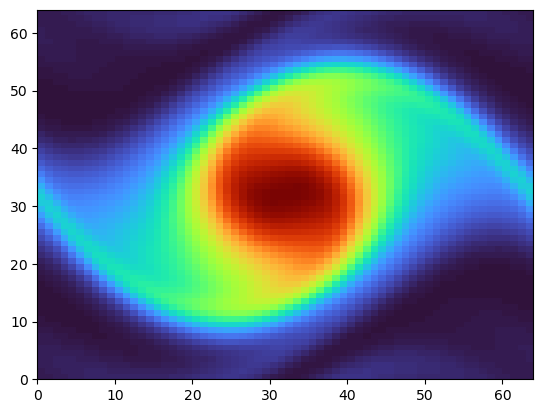

Iteration 	 12500, time 	 9.962503, time remaining 	 -8.962503


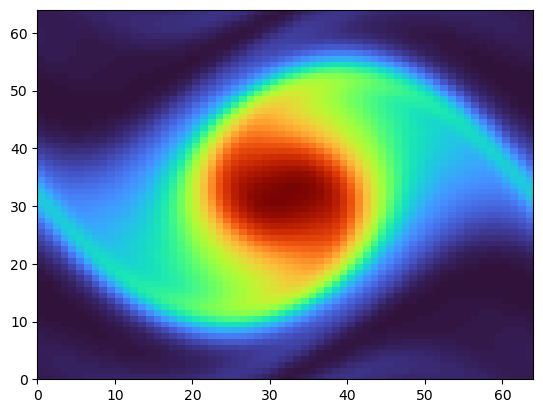

Iteration 	 12600, time 	 10.042142, time remaining 	 -9.042142


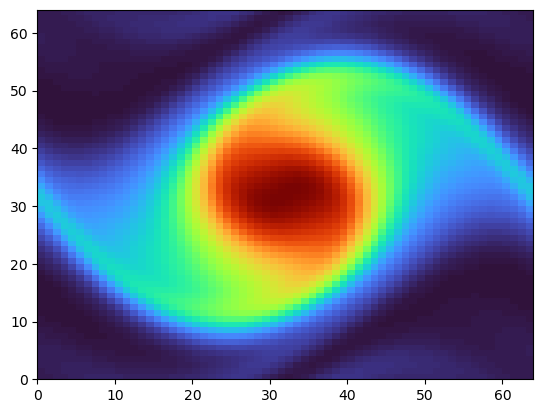

Iteration 	 12700, time 	 10.121784, time remaining 	 -9.121784


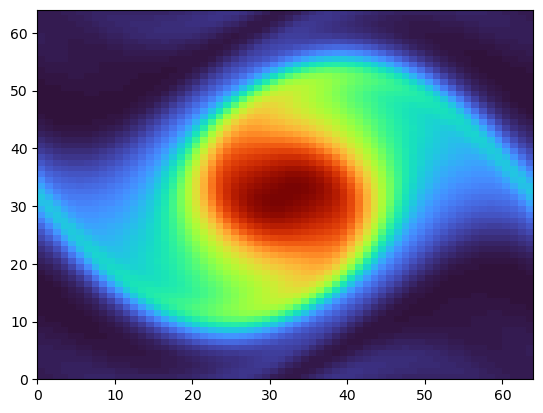

Iteration 	 12800, time 	 10.201432, time remaining 	 -9.201432


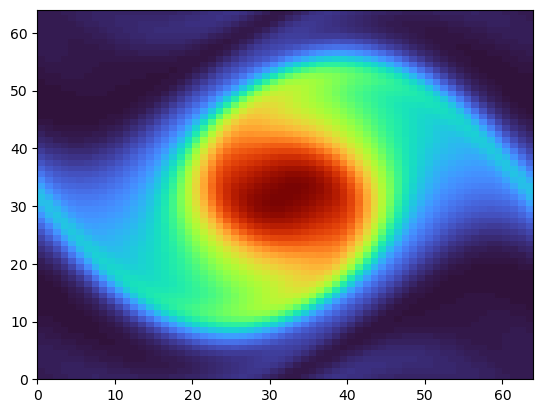

Iteration 	 12900, time 	 10.281081, time remaining 	 -9.281081


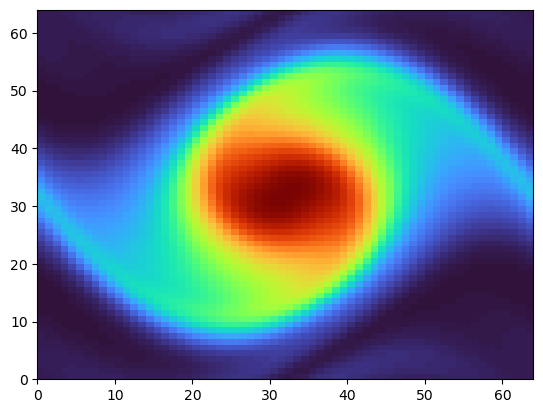

Iteration 	 13000, time 	 10.360734, time remaining 	 -9.360734


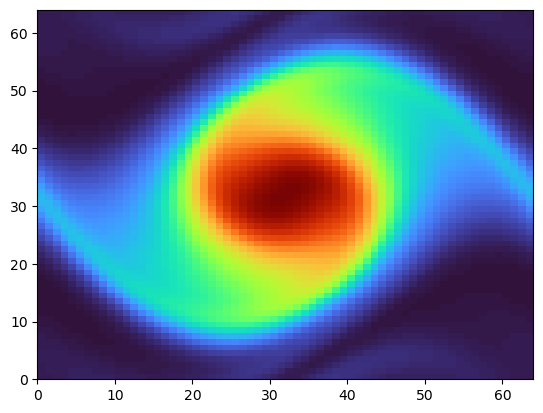

Iteration 	 13100, time 	 10.440393, time remaining 	 -9.440393


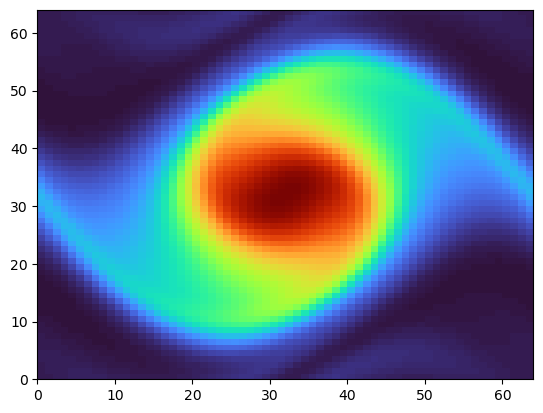

Iteration 	 13200, time 	 10.520060, time remaining 	 -9.520060


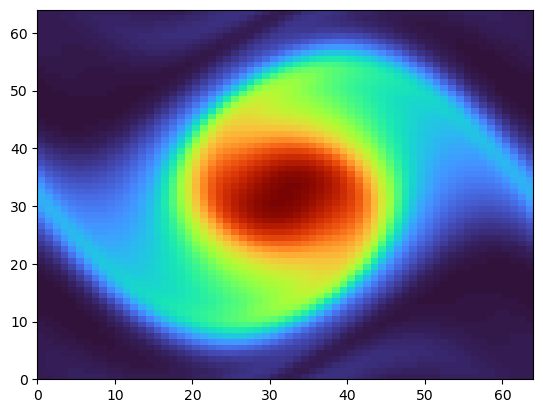

Iteration 	 13300, time 	 10.599738, time remaining 	 -9.599738


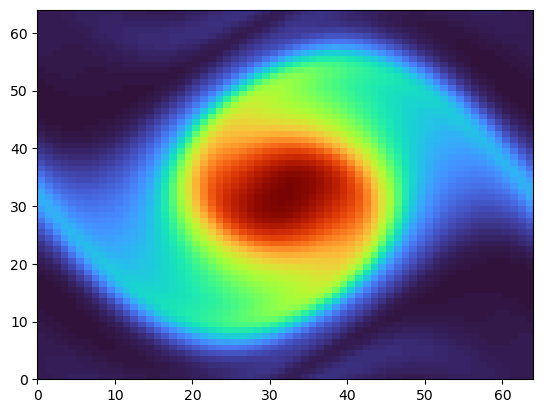

Iteration 	 13400, time 	 10.679421, time remaining 	 -9.679421


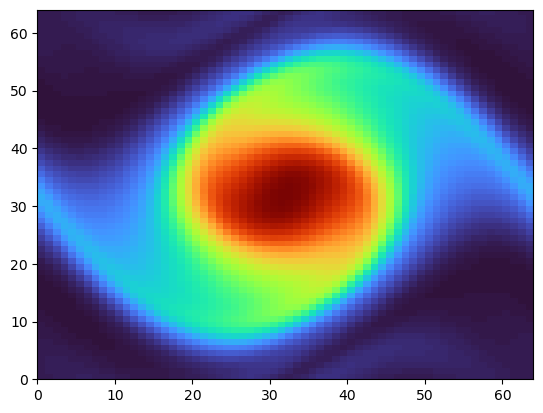

Iteration 	 13500, time 	 10.759113, time remaining 	 -9.759113


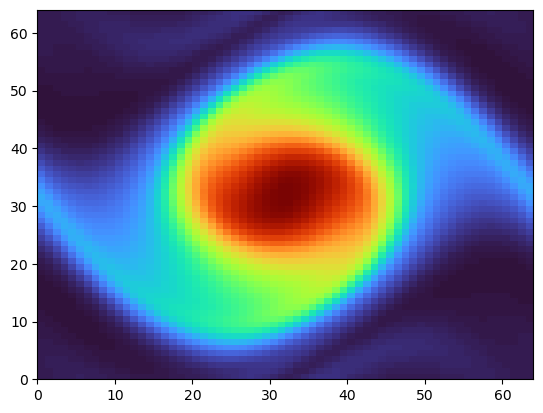

Iteration 	 13600, time 	 10.838814, time remaining 	 -9.838814


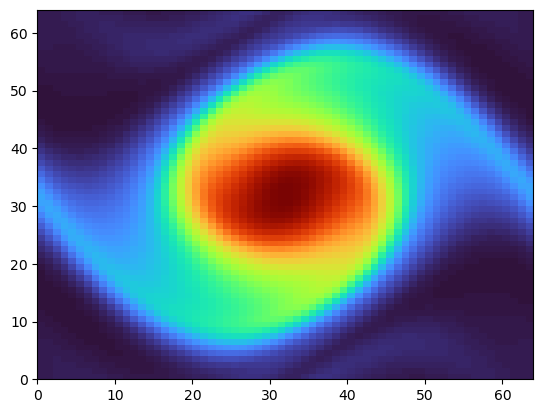

Iteration 	 13700, time 	 10.918526, time remaining 	 -9.918526


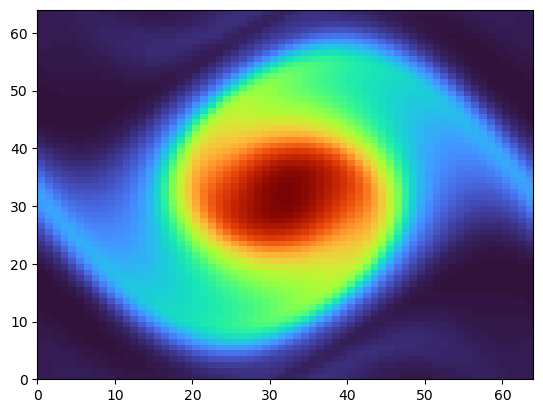

Iteration 	 13800, time 	 10.998250, time remaining 	 -9.998250


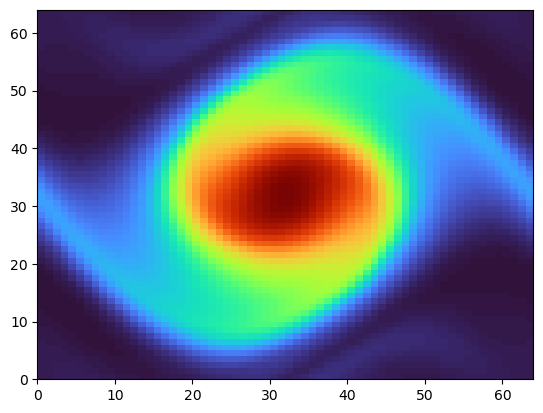

Iteration 	 13900, time 	 11.077986, time remaining 	 -10.077986


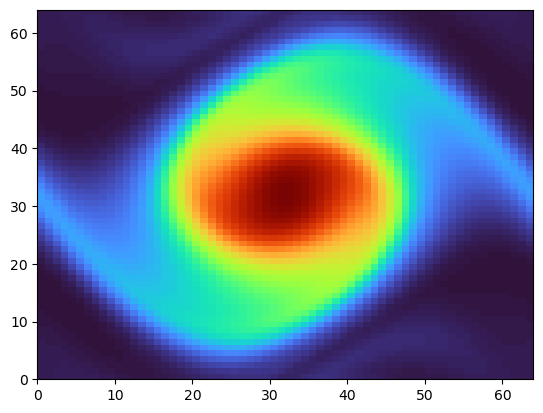

Iteration 	 14000, time 	 11.157733, time remaining 	 -10.157733


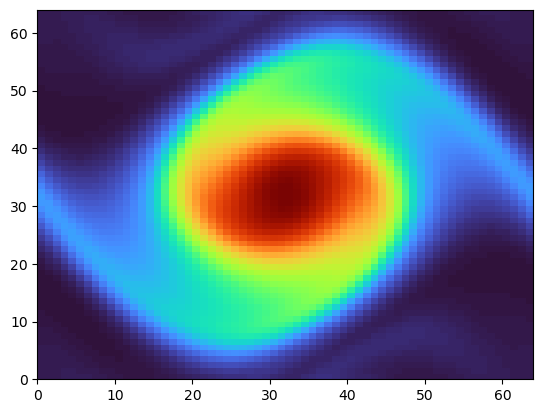

Iteration 	 14100, time 	 11.237491, time remaining 	 -10.237491


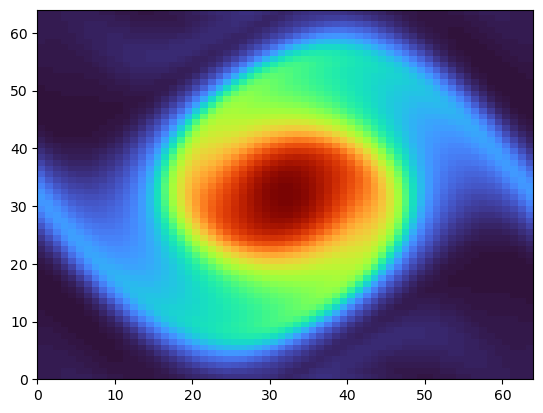

Iteration 	 14200, time 	 11.317259, time remaining 	 -10.317259


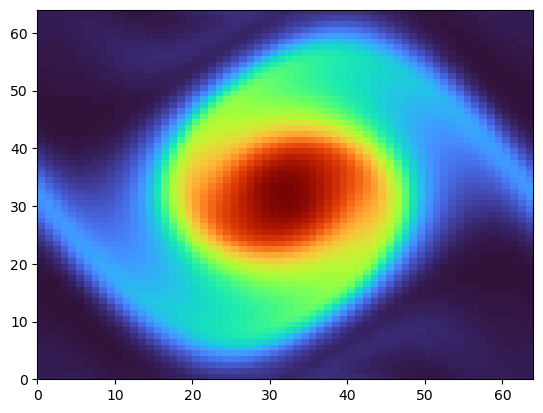

Iteration 	 14300, time 	 11.397040, time remaining 	 -10.397040


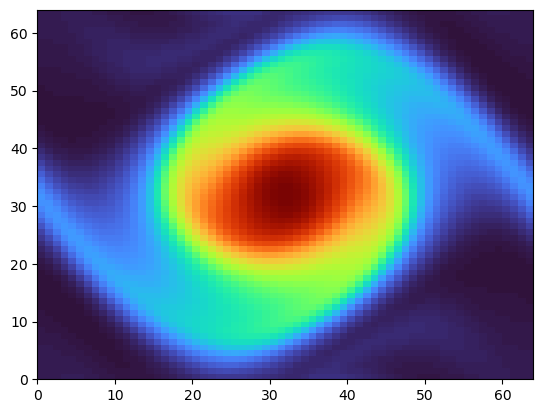

Iteration 	 14400, time 	 11.476832, time remaining 	 -10.476832


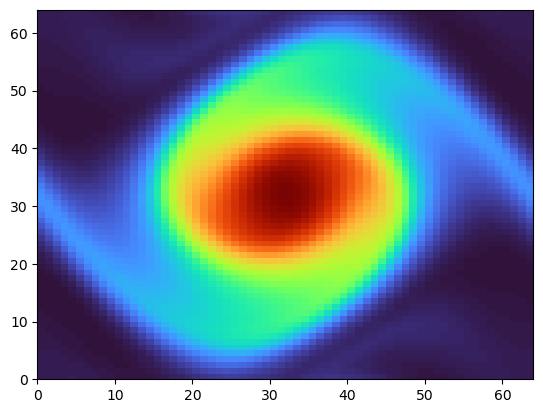

Iteration 	 14500, time 	 11.556637, time remaining 	 -10.556637


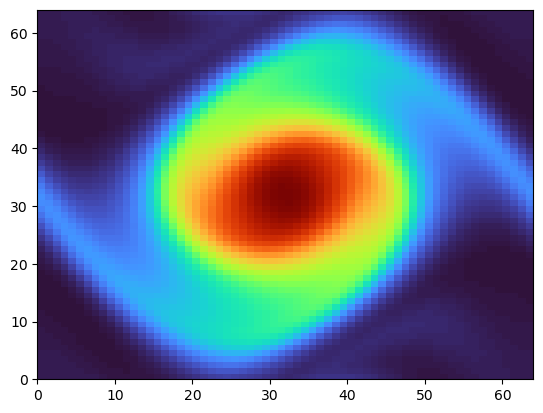

Iteration 	 14600, time 	 11.636455, time remaining 	 -10.636455


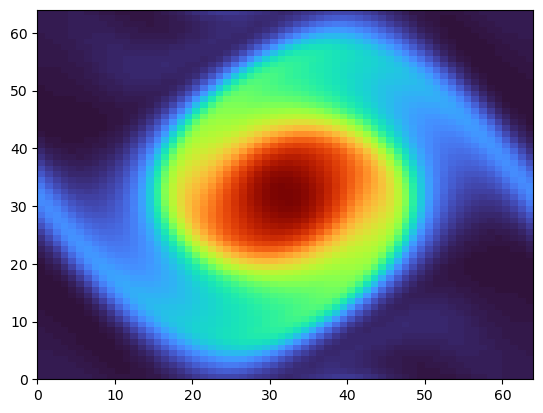

Iteration 	 14700, time 	 11.716284, time remaining 	 -10.716284


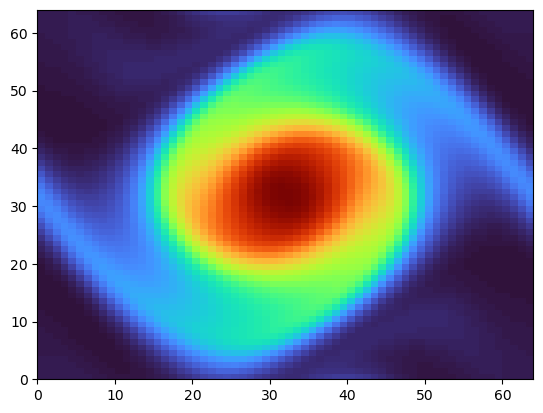

Iteration 	 14800, time 	 11.796127, time remaining 	 -10.796127


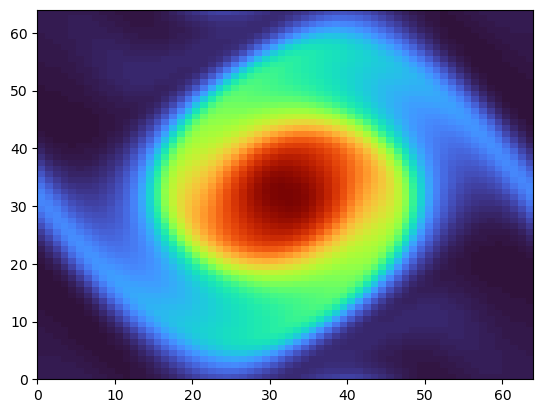

Iteration 	 14900, time 	 11.875980, time remaining 	 -10.875980


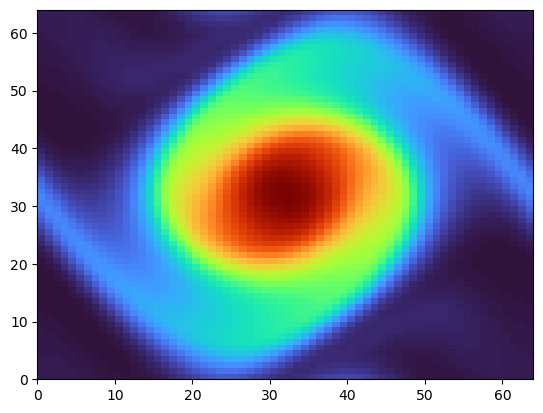

Iteration 	 15000, time 	 11.955844, time remaining 	 -10.955844


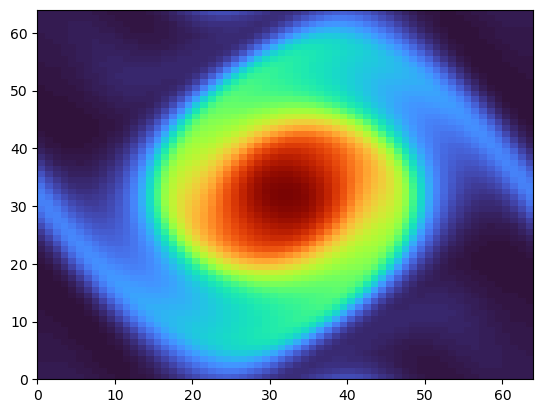

finished


In [11]:
%matplotlib inline
# build fluid and solver
grid_size = 64
flow = Fluid(grid_size, grid_size, 100)
flow.init_solver()
#flow.init_field(McWilliams)#, sigma=0.7)
#flow.w = np.random.normal(0,10,(64,64))
A = 5
alpha = 0.1
x1 = 3
x2 = -3
y1 = -3
y2 = 3

lin = np.linspace(-10,10, grid_size)
x,y = np.meshgrid(lin, lin)

flow.w =  A*(np.exp(-alpha*((x - x1)**2 + (y - y1)**2)) + np.exp(-alpha*((x - x2)**2 + (y - y2)**2)))
plt.pcolormesh(flow.w)
plt.show()
flow.wh = rfft2(flow.w, workers=flow.fftw_num_threads)
stop = 1
every = 100
j = 0
u = []
for i in range(15000):
    #  update using RK
    #print(i)
    flow.update()
    if(flow.it % every == 0):
        #print(i)
        print("Iteration \t %d, time \t %f, time remaining \t %f" %(flow.it,
                      flow.time, stop-flow.time))
        u.append(np.fft.irfft2(flow.wh, axes=(-2, -1)))
        plt.pcolormesh(u[j], cmap="turbo")
        j += 1
        plt.show()
print("finished")


In [12]:
import matplotlib.animation as animation
%matplotlib tk


def plot_fluid(u_k):
    # Clear the current plot figure
    plt.clf()

    plt.title(f"Navier-Stokes-Equation")
    plt.xlabel("x")
    plt.ylabel("y")
    # This is to plot u_k (u at time-step k)
    plt.imshow(u_k, cmap="inferno")#, vmin=0, vmax=1)#, vmin=300, vmax=1000)
    plt.colorbar()

    return plt

def animate(k):
    plt_ = plot_fluid(u[k])
    return plt_,



anim = animation.FuncAnimation(plt.figure(), animate, interval=1, 
                               frames=len(u))
anim.save("navier_stokes8.gif")